In [1]:
import datetime
import json
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import requests
from scipy.ndimage import filters
import time
from tqdm import tqdm

import replays_to_database

%matplotlib inline
jtplot.style()
pd.set_option('max_colwidth', 400)
pd.set_option('max_rows', 200)

DESTINATION = 'episode_scraping/replays_by_sub_id'

base_url = "https://www.kaggle.com/requests/EpisodeService/"
get_url = base_url + "GetEpisodeReplay"
list_url = base_url + "ListEpisodes"
BUFFER = 2.

sub_id_to_model_name_df = pd.read_csv(f'{DESTINATION}/sub_id_to_model_name.csv', index_col='sub_id')
sub_id_to_model_names_dict = sub_id_to_model_name_df.to_dict()['model_name']

for sub_id in sub_id_to_model_names_dict.keys():
    Path(f'{DESTINATION}/{sub_id}').mkdir(exist_ok=True)

assert len(np.unique(list(sub_id_to_model_name_df.index))) == len(sub_id_to_model_name_df)
sub_id_to_model_name_df

model_name
sub_id                                                                         
19120498                                                 Coffee_Candy_top_model
19278412                                                       Nagiss_top_model
19332390  a3c_agent_small_8_64_32_2-weighted_probs_ensemble_deterministic-v1_40
19332147            a3c_agent_small_8_64_32_2-mean_probs_ensemble_deterministic
19332024      awac_agent_small_8_64_32_1_norm-mean_probs_ensemble_deterministic
19318218                 a3c_agent_small_8_64_32_2-equal_ensemble_deterministic
19316113                 a3c_agent_small_8_64_32_2-equal_ensemble_deterministic
19316073                 a3c_agent_small_8_64_32_2-equal_ensemble_deterministic
19305767                      a3c_agent_small_8_32-equal_ensemble_deterministic
19305418                                    a3c_agent_small_8_32-equal_ensemble
19305651                 a3c_agent_small_8_64_32_2-equal_ensemble_deterministic
19298895                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19298869                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19298835                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19298789                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19283635                                        a3c_agent_small_8_64_32_2_v2-30
19280141                                        a3c_agent_small_8_64_32_2_v2-30
19279992                       a3c_agent_small_8_64_32_2_v1-11100_deterministic
19279736                          a3c_agent_small_8_64_32_2_v2-30_deterministic
19279084                                        a3c_agent_small_8_64_32_2_v2-30
19279054                                     a3c_agent_small_8_64_32_2_v1-11100
19264768                                      a3c_agent_small_8_64_32_2_v1-6400
19264185                        a3c_agent_small_8_64_32_2_v1-6400_deterministic
19264159                                      a3c_agent_small_8_64_32_2_v1-6400
19261534               awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
19253761                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19246586                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19246551                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19246494                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19238941                                         a3c_agent_small_6_64_2_v1-4100
19238860                           a3c_agent_small_6_64_2_v1-4100_deterministic
19233560                                 a3c_agent_small_8_32-410_deterministic
19233501                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19233404                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19233081                                 a3c_agent_small_8_32-410_deterministic
19232590                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19219774                                 a3c_agent_small_8_32-410_deterministic
19219706                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19219346                                 a3c_agent_small_8_32-410_deterministic
19217835                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19217493                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19205259                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19205211               awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
19205145                                 a3c_agent_small_8_32-410_deterministic
19205090                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19205062               awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
19175870                   awac_agent_small_8_64_32_1_norm_v1-230_deterministic
19015839               awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
19190530                   awac_agent_small_8_64_32_1_norm_v2-750_det

In [2]:
def saveEpisode(sub_id, epid, rj):
    assert Path(f'{DESTINATION}/{sub_id}').is_dir()
    if Path(f'{DESTINATION}/{sub_id}/{epid}.json').exists():
        return False
    else:
        # request
        re = requests.post(get_url, json = {"EpisodeId": int(epid)})

        # save replaysub_id_to_model_names_dict
        with open(f'{DESTINATION}/{sub_id}/{epid}.json', 'w') as f:
            f.write(re.json()['result']['replay'])

        # save episode info
        with open(f'{DESTINATION}/{sub_id}/{epid}_info.json', 'w') as f:
            json.dump([r for r in rj['result']['episodes'] if r['id']==epid][0], f)
        return True

## Scrape replays

In [3]:
def slow_down(n_requests, start_time):
    if n_requests >= (datetime.datetime.now() - start_time).seconds:
        time.sleep(n_requests - (datetime.datetime.now() - start_time).seconds + 0.1)

start_time = datetime.datetime.now()
r = BUFFER
for sub_id, model_name in list(sub_id_to_model_names_dict.items()):
    result = requests.post(list_url, json = {"submissionId":  int(sub_id)})
    r += 1
    slow_down(r, start_time)
    team_json = result.json()
    team_df = pd.DataFrame(team_json['result']['episodes'])
    print(f'{len(team_df)} games for {sub_id}: {model_name}')
    
    for i in range(len(team_df)):
        epid = team_df.id.iloc[i]

        filename = f'{DESTINATION}/{sub_id}/{epid}.json'
        if saveEpisode(sub_id, epid, team_json):
            try:
                size = Path(filename).stat().st_size / 1e6
                print(f'Saved Episode #{epid} @ {size:.1f}MB')
            except:
                print(f'{filename} did not save correctly')    
            r += 1
            slow_down(r, start_time)
        else:
            # print(f'{filename} was saved previously')
            pass
    print()

127 games for 19120498: Coffee_Candy_top_model



JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

## Convert scraped replays to visualization format

In [21]:
FORCE = False

for sub_id, model_name in sub_id_to_model_names_dict.items():
    replay_paths = list(Path(f'{DESTINATION}/{sub_id}').glob('*[0-9].json'))
    print(f'Converting {len(replay_paths)} replays to visualization format for {sub_id}: {model_name}')
    #time.sleep(0.5)
    
    for rp in tqdm(replay_paths):
        if not Path(f'{DESTINATION}/{sub_id}/{rp.stem}_visualization_dict.pkl').exists() or FORCE:
            replay = replays_to_database.read_json(rp)
            replay_info = replays_to_database.read_json(rp.parent / (rp.stem + '_info.json'))
            if replay_info['agents'][0]['submissionId'] == sub_id:
                my_team_idx = 0
            elif replay_info['agents'][1]['submissionId'] == sub_id:
                my_team_idx = 1
            else:
                raise RuntimeError('Neither agent has the correct submissionId')
            replay_viz_dict = replays_to_database.convert_replay_for_visualization(replay, my_team_idx)

            if replay_viz_dict is not None:
                with open(f'{DESTINATION}/{sub_id}/{rp.stem}_visualization_dict.pkl', 'wb') as f:
                    pickle.dump(replay_viz_dict, f, pickle.HIGHEST_PROTOCOL)
            else:
                print(f'Skipping replay {sub_id}/{rp.stem}, as it is invalid')

  0%|          | 0/61 [00:00<?, ?it/s]

Converting 127 replays to visualization format for 19120498: Coffee_Candy_top_model
Converting 61 replays to visualization format for 19278412: Nagiss_top_model


  0%|          | 0/42 [00:00<?, ?it/s]

Converting 43 replays to visualization format for 19318218: a3c_agent_small_8_64_32_2-equal_ensemble_deterministic
Converting 42 replays to visualization format for 19316113: a3c_agent_small_8_64_32_2-equal_ensemble_deterministic
Skipping replay 19316113/13730836, as it is invalid


  0%|          | 0/43 [00:00<?, ?it/s]

Converting 43 replays to visualization format for 19316073: a3c_agent_small_8_64_32_2-equal_ensemble_deterministic


  0%|          | 0/53 [00:00<?, ?it/s]

Converting 50 replays to visualization format for 19305767: a3c_agent_small_8_32-equal_ensemble_deterministic
Skipping replay 19305767/13754501, as it is invalid
Converting 53 replays to visualization format for 19305418: a3c_agent_small_8_32-equal_ensemble


  0%|          | 0/48 [00:00<?, ?it/s]

Skipping replay 19305418/13698981, as it is invalid
Converting 48 replays to visualization format for 19305651: a3c_agent_small_8_64_32_2-equal_ensemble_deterministic


  0%|          | 0/52 [00:00<?, ?it/s]

Converting 53 replays to visualization format for 19298895: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Skipping replay 19298895/13508103, as it is invalid
Converting 52 replays to visualization format for 19298869: awac_agent_small_8_64_32_1_norm_v1-230_deterministic


  0%|          | 0/52 [00:00<?, ?it/s]

Skipping replay 19298869/13507470, as it is invalid
Skipping replay 19298869/13500608, as it is invalid
Converting 52 replays to visualization format for 19298835: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Skipping replay 19298835/13714206, as it is invalid


  0%|          | 0/62 [00:00<?, ?it/s]

Converting 53 replays to visualization format for 19298789: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 62 replays to visualization format for 19283635: a3c_agent_small_8_64_32_2_v2-30
Skipping replay 19283635/13311673, as it is invalid


 68%|██████▊   | 42/62 [00:00<00:00, 255.90it/s]

Skipping replay 19283635/13300480, as it is invalid
Skipping replay 19283635/13301728, as it is invalid


  0%|          | 0/65 [00:00<?, ?it/s]

Converting 60 replays to visualization format for 19280141: a3c_agent_small_8_64_32_2_v2-30
Skipping replay 19280141/13318732, as it is invalid
Converting 65 replays to visualization format for 19279992: a3c_agent_small_8_64_32_2_v1-11100_deterministic


  0%|          | 0/62 [00:00<?, ?it/s]

Converting 65 replays to visualization format for 19279736: a3c_agent_small_8_64_32_2_v2-30_deterministic
Skipping replay 19279736/13291990, as it is invalid
Converting 62 replays to visualization format for 19279084: a3c_agent_small_8_64_32_2_v2-30


  0%|          | 0/69 [00:00<?, ?it/s]

Converting 61 replays to visualization format for 19279054: a3c_agent_small_8_64_32_2_v1-11100
Converting 73 replays to visualization format for 19264768: a3c_agent_small_8_64_32_2_v1-6400
Converting 69 replays to visualization format for 19264185: a3c_agent_small_8_64_32_2_v1-6400_deterministic


  0%|          | 0/71 [00:00<?, ?it/s]

Converting 74 replays to visualization format for 19264159: a3c_agent_small_8_64_32_2_v1-6400
Skipping replay 19264159/13221901, as it is invalid
Converting 71 replays to visualization format for 19261534: awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic


  0%|          | 0/78 [00:00<?, ?it/s]

Skipping replay 19261534/13339154, as it is invalid
Converting 78 replays to visualization format for 19253761: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 78 replays to visualization format for 19246586: awac_agent_small_8_64_32_1_norm_v1-230_deterministic


  0%|          | 0/75 [00:00<?, ?it/s]

Skipping replay 19246586/13734708, as it is invalid
Skipping replay 19246586/13782821, as it is invalid
Converting 75 replays to visualization format for 19246551: awac_agent_small_8_64_32_1_norm_v1-230_deterministic


  0%|          | 0/78 [00:00<?, ?it/s]

Converting 76 replays to visualization format for 19246494: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Skipping replay 19246494/13220011, as it is invalid
Converting 78 replays to visualization format for 19238941: a3c_agent_small_6_64_2_v1-4100


  0%|          | 0/84 [00:00<?, ?it/s]

Skipping replay 19238941/13790818, as it is invalid
Converting 84 replays to visualization format for 19238860: a3c_agent_small_6_64_2_v1-4100_deterministic


  0%|          | 0/86 [00:00<?, ?it/s]

Skipping replay 19238860/13808652, as it is invalid
Converting 86 replays to visualization format for 19233560: a3c_agent_small_8_32-410_deterministic
Skipping replay 19233560/13492208, as it is invalid


  0%|          | 0/100 [00:00<?, ?it/s]

Skipping replay 19233560/13787717, as it is invalid
Converting 78 replays to visualization format for 19233501: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 82 replays to visualization format for 19233404: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 80 replays to visualization format for 19233081: a3c_agent_small_8_32-410_deterministic
Skipping replay 19233081/13717459, as it is invalid
Converting 81 replays to visualization format for 19232590: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 87 replays to visualization format for 19219774: a3c_agent_small_8_32-410_deterministic
Converting 97 replays to visualization format for 19219706: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 94 replays to visualization format for 19219346: a3c_agent_small_8_32-410_deterministic
Converting 91 replays to visualization format for 19217835: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 91 replays to visualiza

  0%|          | 0/118 [00:00<?, ?it/s]

Skipping replay 19205090/13778620, as it is invalid
Converting 89 replays to visualization format for 19205062: awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
Converting 102 replays to visualization format for 19175870: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 227 replays to visualization format for 19015839: awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
Converting 96 replays to visualization format for 19190530: awac_agent_small_8_64_32_1_norm_v2-750_deterministic
Converting 106 replays to visualization format for 19190485: awac_agent_small_8_64_32_1_norm_v2-750_deterministic
Converting 109 replays to visualization format for 19175191: a3c_agent_small_8_32-410_deterministic
Converting 102 replays to visualization format for 19189372: awac_agent_small_8_64_32_1_norm_v2-750_deterministic
Converting 107 replays to visualization format for 19187396: awac_agent_small_8_128_64_1_norm_v2-350_deterministic
Converting 109 replays to visualization for

  0%|          | 0/127 [00:00<?, ?it/s]

Skipping replay 19161908/13140502, as it is invalid
Converting 118 replays to visualization format for 19161882: a3c_agent_small_2_32_1_v3-100_deterministic
Converting 118 replays to visualization format for 19161414: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 107 replays to visualization format for 19161265: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Skipping replay 19161265/13435837, as it is invalid
Converting 124 replays to visualization format for 19161241: awac_agent_small_8_64_32_1_norm_v1-230_deterministic
Converting 130 replays to visualization format for 19147006: a3c_agent_small_8_32-790_deterministic
Skipping replay 19147006/13235217, as it is invalid
Converting 127 replays to visualization format for 19146864: a3c_agent_small_8_32-410_deterministic


  0%|          | 0/135 [00:00<?, ?it/s]

Skipping replay 19146864/13143806, as it is invalid
Converting 121 replays to visualization format for 19146628: a3c_agent_small_8_32-410_deterministic
Converting 124 replays to visualization format for 19146474: a3c_agent_small_8_32-410_deterministic
Converting 119 replays to visualization format for 19146003: a3c_agent_small_8_32-410_deterministic
Skipping replay 19146003/13224215, as it is invalid
Converting 134 replays to visualization format for 19129975: awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
Converting 144 replays to visualization format for 19129924: awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic
Skipping replay 19129924/13192202, as it is invalid
Converting 138 replays to visualization format for 19129890: a3c_agent_small_8_32-410_deterministic
Converting 135 replays to visualization format for 19129762: a3c_agent_small_8_32-790_deterministic


100%|██████████| 475/475 [00:00<00:00, 29639.30it/s]

Converting 139 replays to visualization format for 19129707: a3c_agent_small_8_32-410_deterministic
Converting 149 replays to visualization format for 19104699: a3c_agent_small_8_32-410_deterministic
Converting 437 replays to visualization format for 18781054: pull_vegas_slot_machines
Converting 463 replays to visualization format for 18637027: thompson_sampling
Converting 475 replays to visualization format for 18636808: thompson_sampling


## Visualize replays for a specific model type

In [22]:
def generate_fig(model_name=None, sub_id=None, last_n_games=None, save=True):
    assert model_name is not None or sub_id is not None
    if model_name is None:
        model_name = sub_id_to_model_names_dict[sub_id]
        selected_sub_ids = [sub_id]
    else:
        assert sub_id is None
        selected_sub_ids = [sub_id for sub_id in sub_id_to_model_names_dict.keys() if sub_id_to_model_names_dict[sub_id] == model_name]

    visualization_dicts = []
    for si in selected_sub_ids:
        vd_paths = sorted(list(Path(f'{DESTINATION}/{si}').glob('*_visualization_dict.pkl')), key=lambda full_path: full_path.name)
        if last_n_games is not None:
            vd_paths = vd_paths[-last_n_games:]
        for vdp in vd_paths:
            with open(vdp, 'rb') as f:
                visualization_dicts.append(pickle.load(f))

    actual_rewards = np.stack([vd['actual_rewards'] for vd in visualization_dicts], axis=1)
    # expected_rewards = np.stack([vd['expected_rewards'] for vd in visualization_dicts], axis=1)
    actual_advantage = np.vstack([vd['actual_advantage'][0] for vd in visualization_dicts])
    expected_advantage = np.vstack([vd['expected_advantage'][0] for vd in visualization_dicts])

    game_results = np.cumsum(actual_advantage, axis=1)[:, -1]
    n_games = len(game_results)
    score = (np.sum(game_results > 0) + np.sum(game_results == 0) * 0.5) / n_games

    CUMULATIVE_YMAX = 20
    EXPECTED_YMAX = 0.10
    WINDOW_SIZE = 150
    FILTER_MODE = 'reflect'
    # Q = np.linspace(0., 100., 5)
    Q = np.array([5., 25., 50., 75., 95.])
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_rows = 2
    n_cols = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    if sub_id is None:
        suptitle = f'{model_name}\n'
    else:
        suptitle = f'{model_name} - {sub_id}\n'
    is_last = 'last ' if last_n_games is not None else ''
    suptitle += f'{score * 100.:.2f}% winrate over {is_last}{n_games} games\n'
    suptitle += f'Mean scores: {actual_rewards[0].sum(axis=-1).mean():.2f} - {actual_rewards[1].sum(axis=-1).mean():.2f}'
    fig.suptitle(suptitle)

    ax_idx = (0, 0)
    axes[ax_idx].plot(np.median(np.cumsum(expected_advantage, axis=1), axis=0), label='median')
    axes[ax_idx].plot(np.cumsum(expected_advantage.mean(axis=0)), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX, CUMULATIVE_YMAX))
    axes[ax_idx].set_title('Cumulative expected advantage')

    ax_idx = (0, 1)
    axes[ax_idx].plot(np.median(filters.uniform_filter1d(expected_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), axis=0), label='median')
    axes[ax_idx].plot(filters.uniform_filter1d(expected_advantage.mean(axis=0), WINDOW_SIZE, mode=FILTER_MODE), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    axes[ax_idx].set_title('Per-step expected advantage')

    ax_idx = (0, 2)
    axes[ax_idx].plot(np.median(np.cumsum(actual_advantage, axis=1), axis=0), label='median')
    axes[ax_idx].plot(np.cumsum(actual_advantage.mean(axis=0)), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX, CUMULATIVE_YMAX))
    axes[ax_idx].set_title('Cumulative actual advantage')

    ax_idx = (0, 3)
    axes[ax_idx].plot(np.median(filters.uniform_filter1d(actual_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), axis=0), label='median')
    axes[ax_idx].plot(filters.uniform_filter1d(actual_advantage.mean(axis=0), WINDOW_SIZE, mode=FILTER_MODE), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    axes[ax_idx].set_title('Per-step actual advantage')

    ax_idx = (0, 4)
    axes[ax_idx].plot(np.median(np.cumsum(actual_advantage, axis=1) - np.cumsum(expected_advantage, axis=1), axis=0), label='median')
    axes[ax_idx].plot(np.cumsum(actual_advantage.mean(axis=0) - expected_advantage.mean(axis=0)), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX, CUMULATIVE_YMAX))
    axes[ax_idx].set_title('Cumulative luck')

    ax_idx = (1, 0)
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(np.cumsum(expected_advantage, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx + 1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX*5, CUMULATIVE_YMAX*5))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Cumulative expected advantage (percentiles)')

    ax_idx = (1, 1)
    #for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(expected_advantage, WINDOW_SIZE*5, mode=FILTER_MODE, axis=1), Q, axis=0)):
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(expected_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx+1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Per-step expected advantage over time (percentiles)')

    ax_idx = (1, 2)
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(np.cumsum(actual_advantage, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx + 1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX*5, CUMULATIVE_YMAX*5))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Cumulative actual advantage (percentiles)')

    ax_idx = (1, 3)
    #for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(actual_advantage, WINDOW_SIZE*5, mode=FILTER_MODE, axis=1), Q, axis=0)):
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(actual_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx+1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Per-step actual advantage over time (percentiles)')

    ax_idx = (1, 4)
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(np.cumsum(actual_advantage - expected_advantage, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx + 1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX*5, CUMULATIVE_YMAX*5))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Cumulative luck (percentiles)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    if save:
        if sub_id is None:
            save_fig_folder = 'saved_figures/online_opponents'
            save_fig_title = model_name
        else:
            save_fig_folder = 'saved_figures/online_opponents/specific_submissions'
            save_fig_title = f'{model_name}__{sub_id}'
        Path(save_fig_folder).mkdir(exist_ok=True)
        fig.savefig(f'{save_fig_folder}/{save_fig_title}.png', dpi=100)
    plt.show()

## Generate figures given specific submission IDs

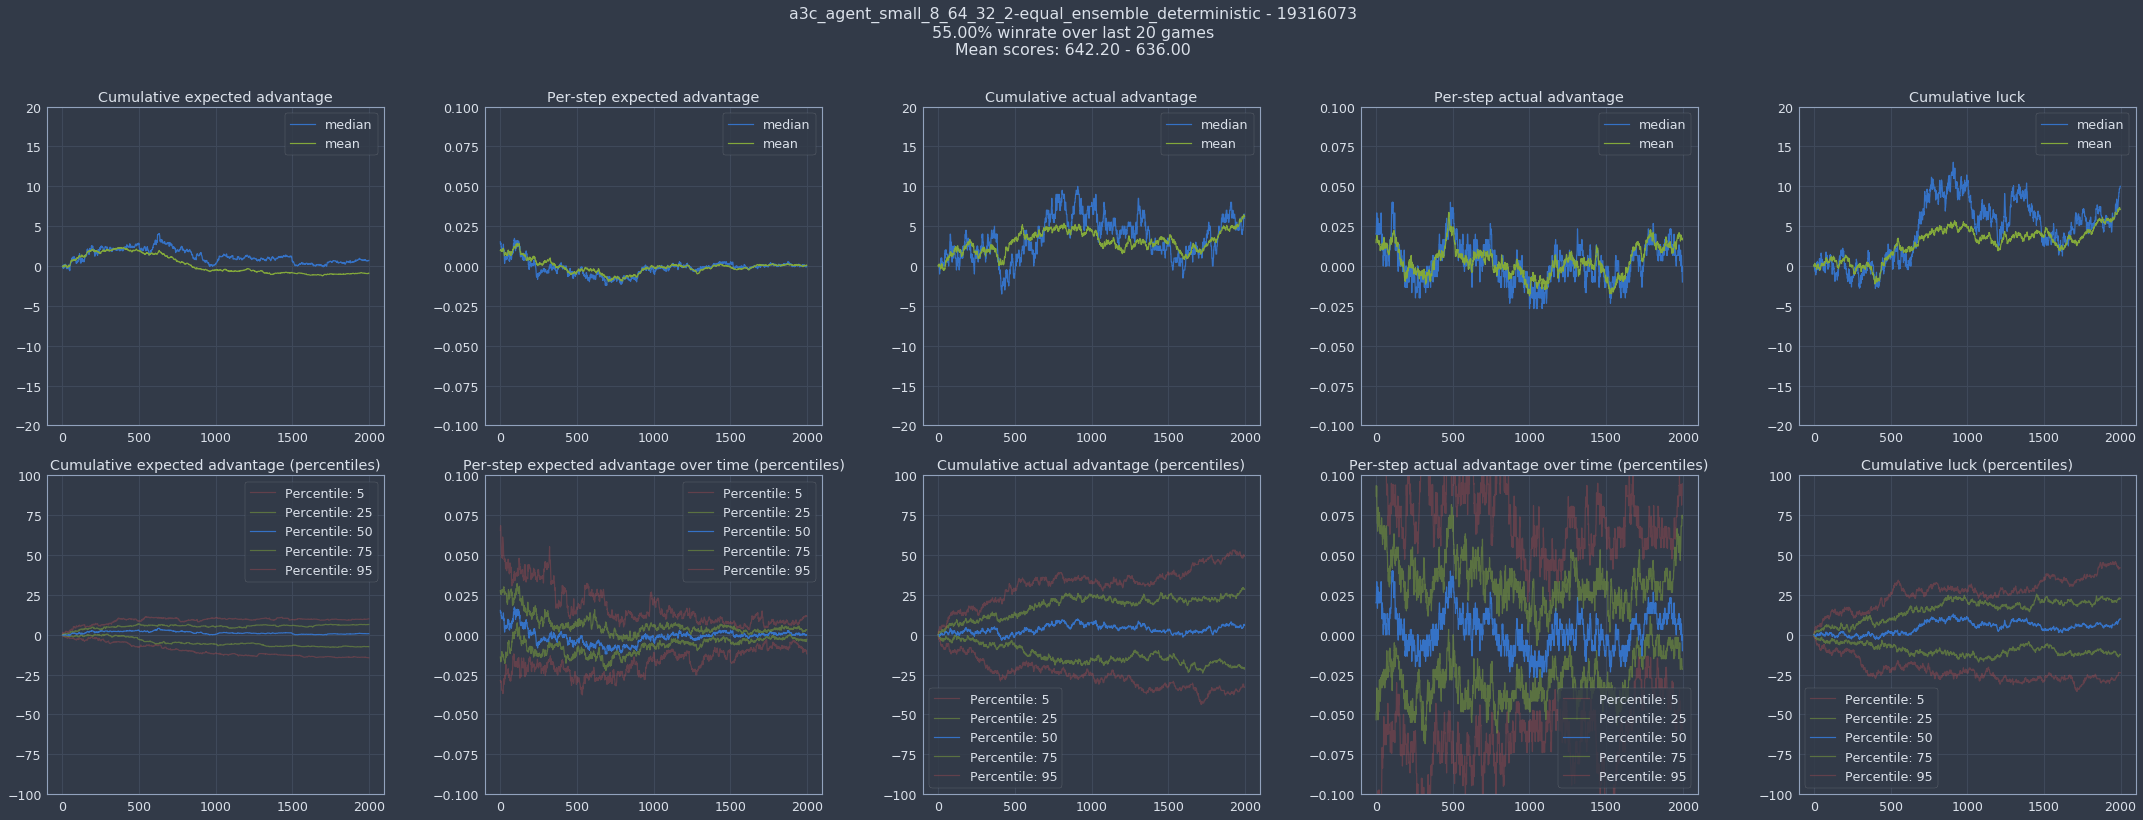

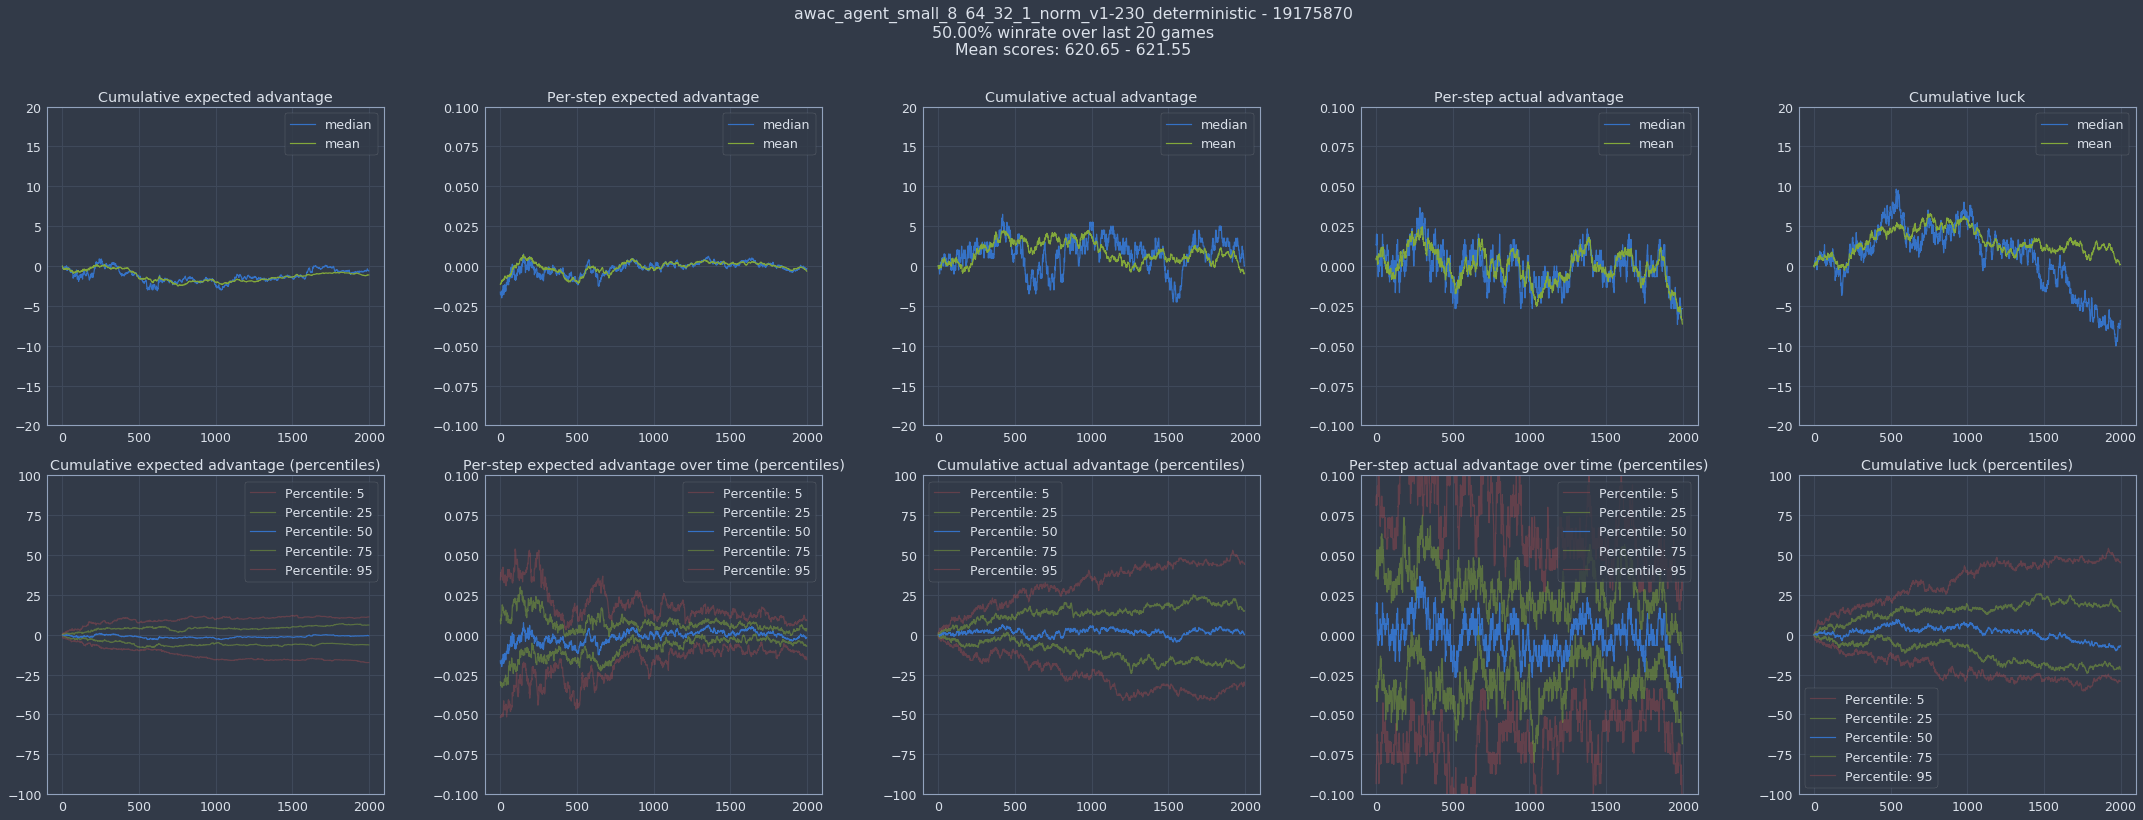

In [23]:
SUB_IDS = [19316073, 19175870]

for si in SUB_IDS:
    generate_fig(sub_id=si, last_n_games=20)

## Generate figures given specific model names

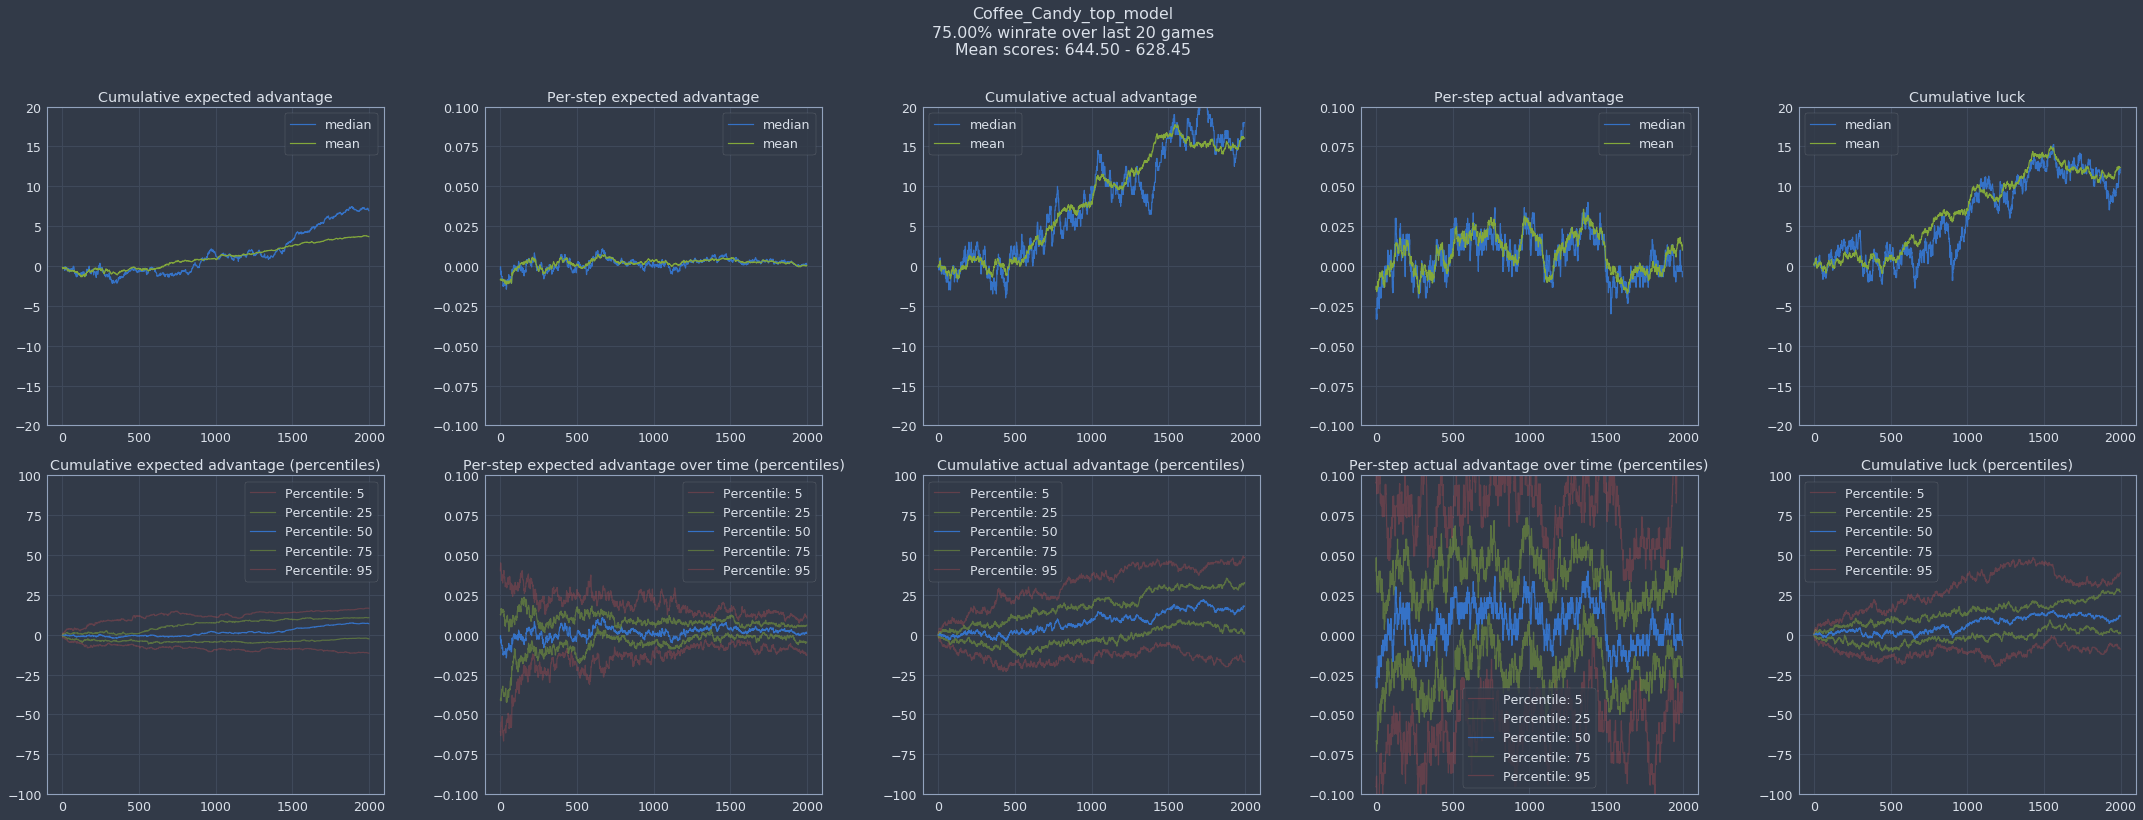

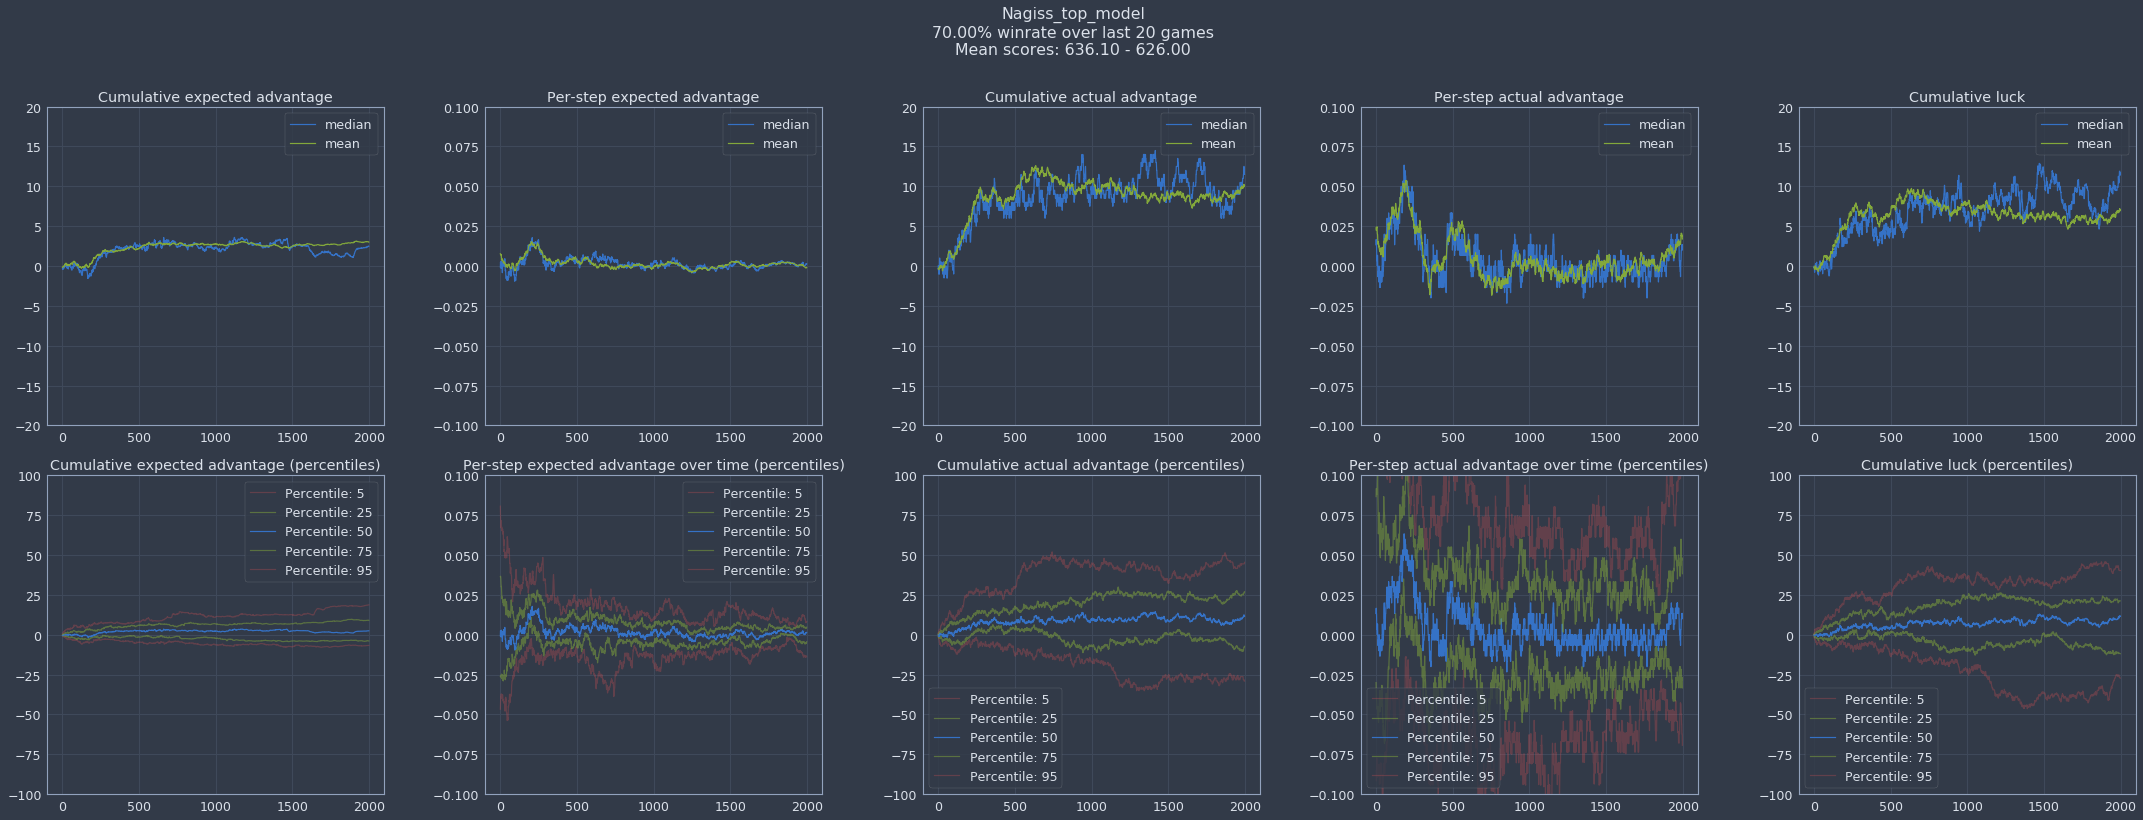

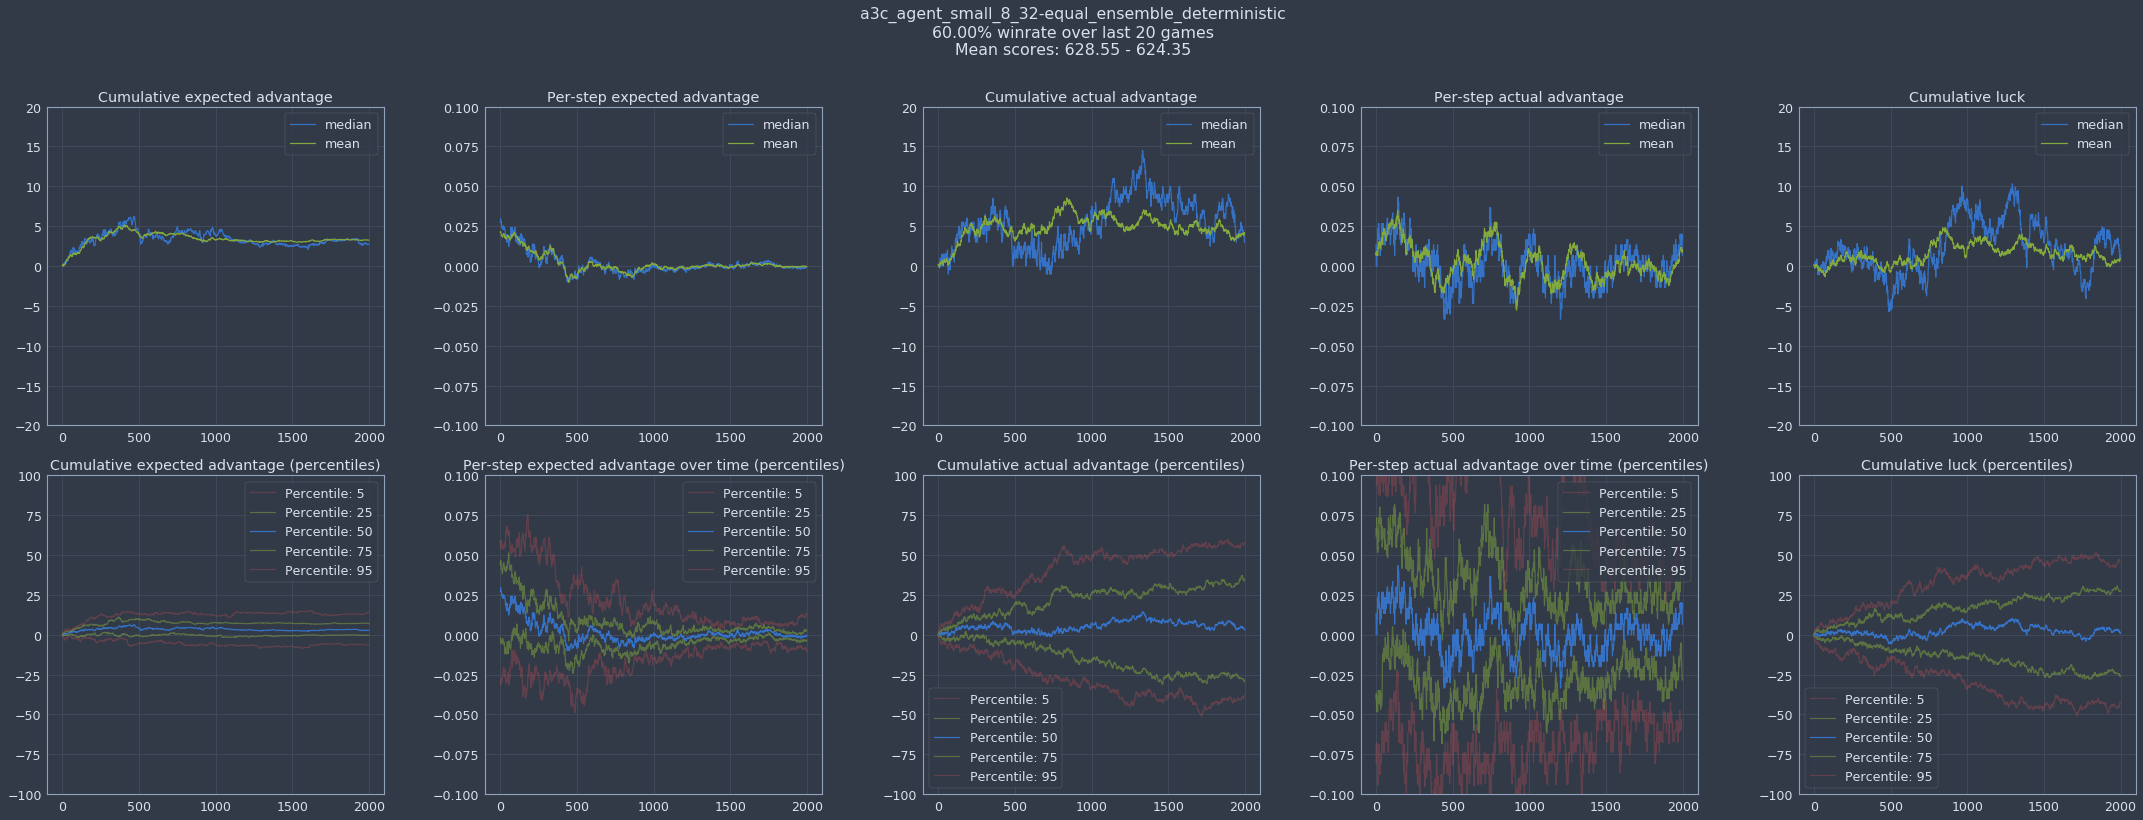

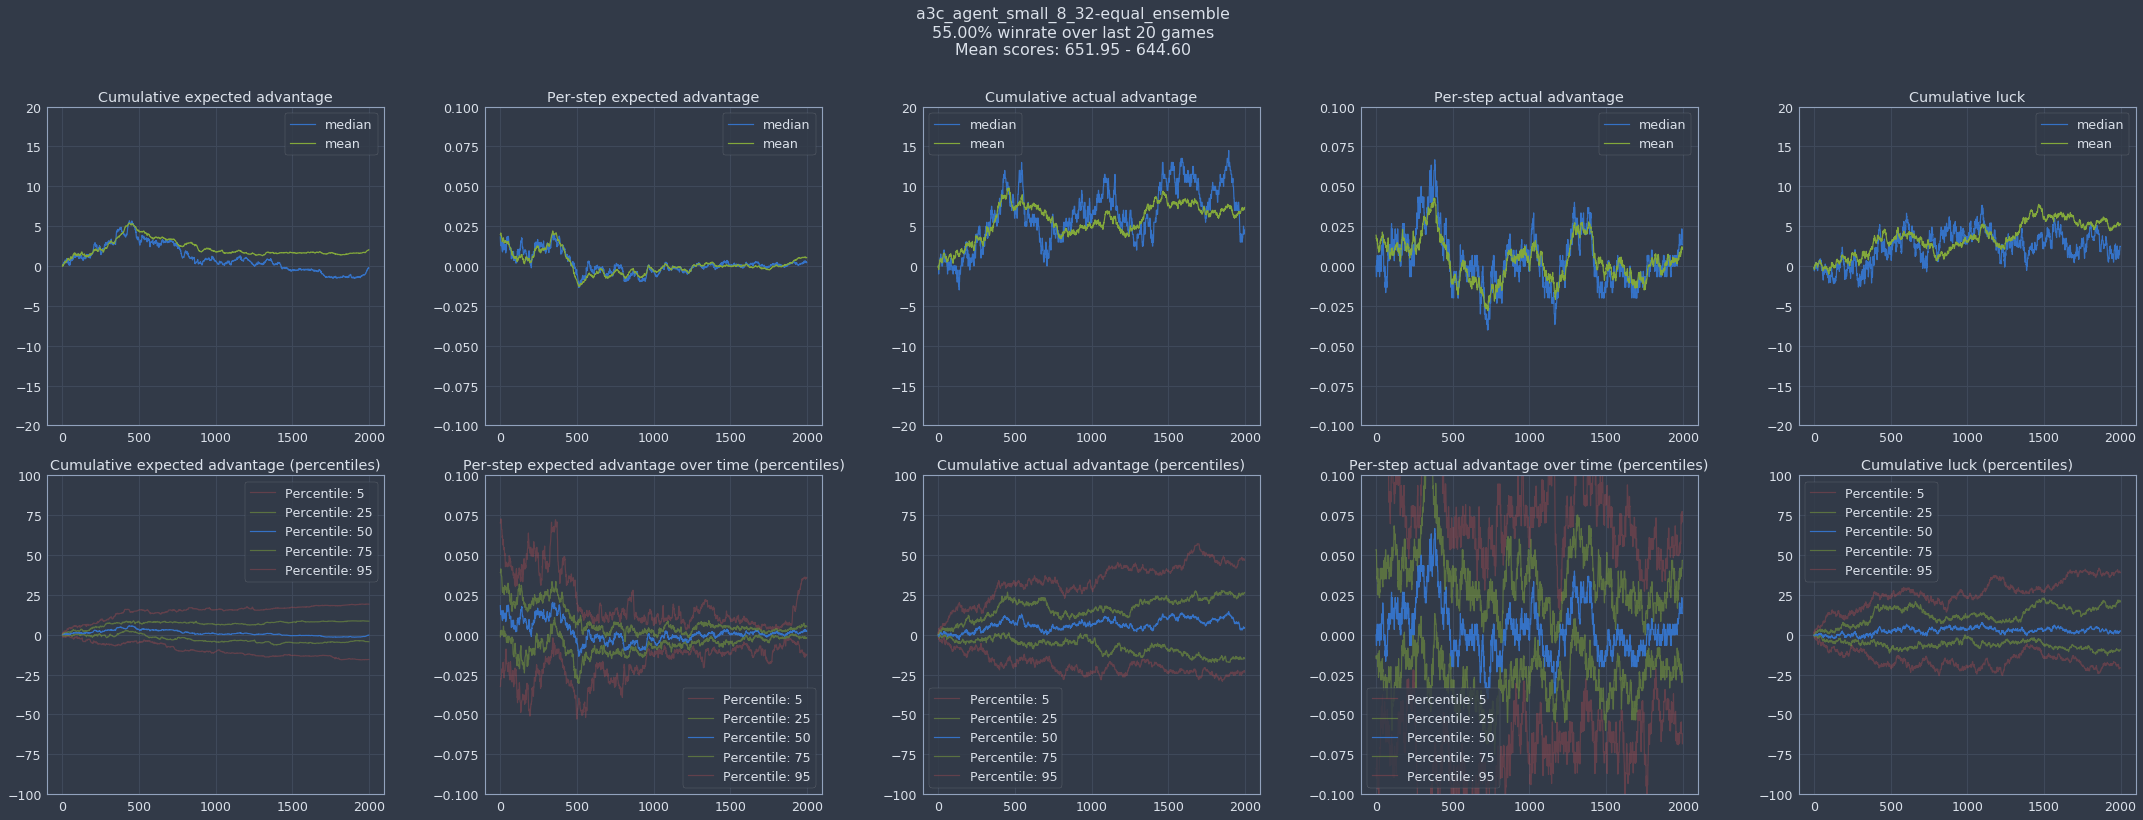

In [24]:
MODEL_NAMES = ['Coffee_Candy_top_model', 'Nagiss_top_model', 'a3c_agent_small_8_32-equal_ensemble_deterministic', 'a3c_agent_small_8_32-equal_ensemble']

for mn in MODEL_NAMES:
    generate_fig(model_name=mn, last_n_games=20, save=False)

## Generate figures for all models

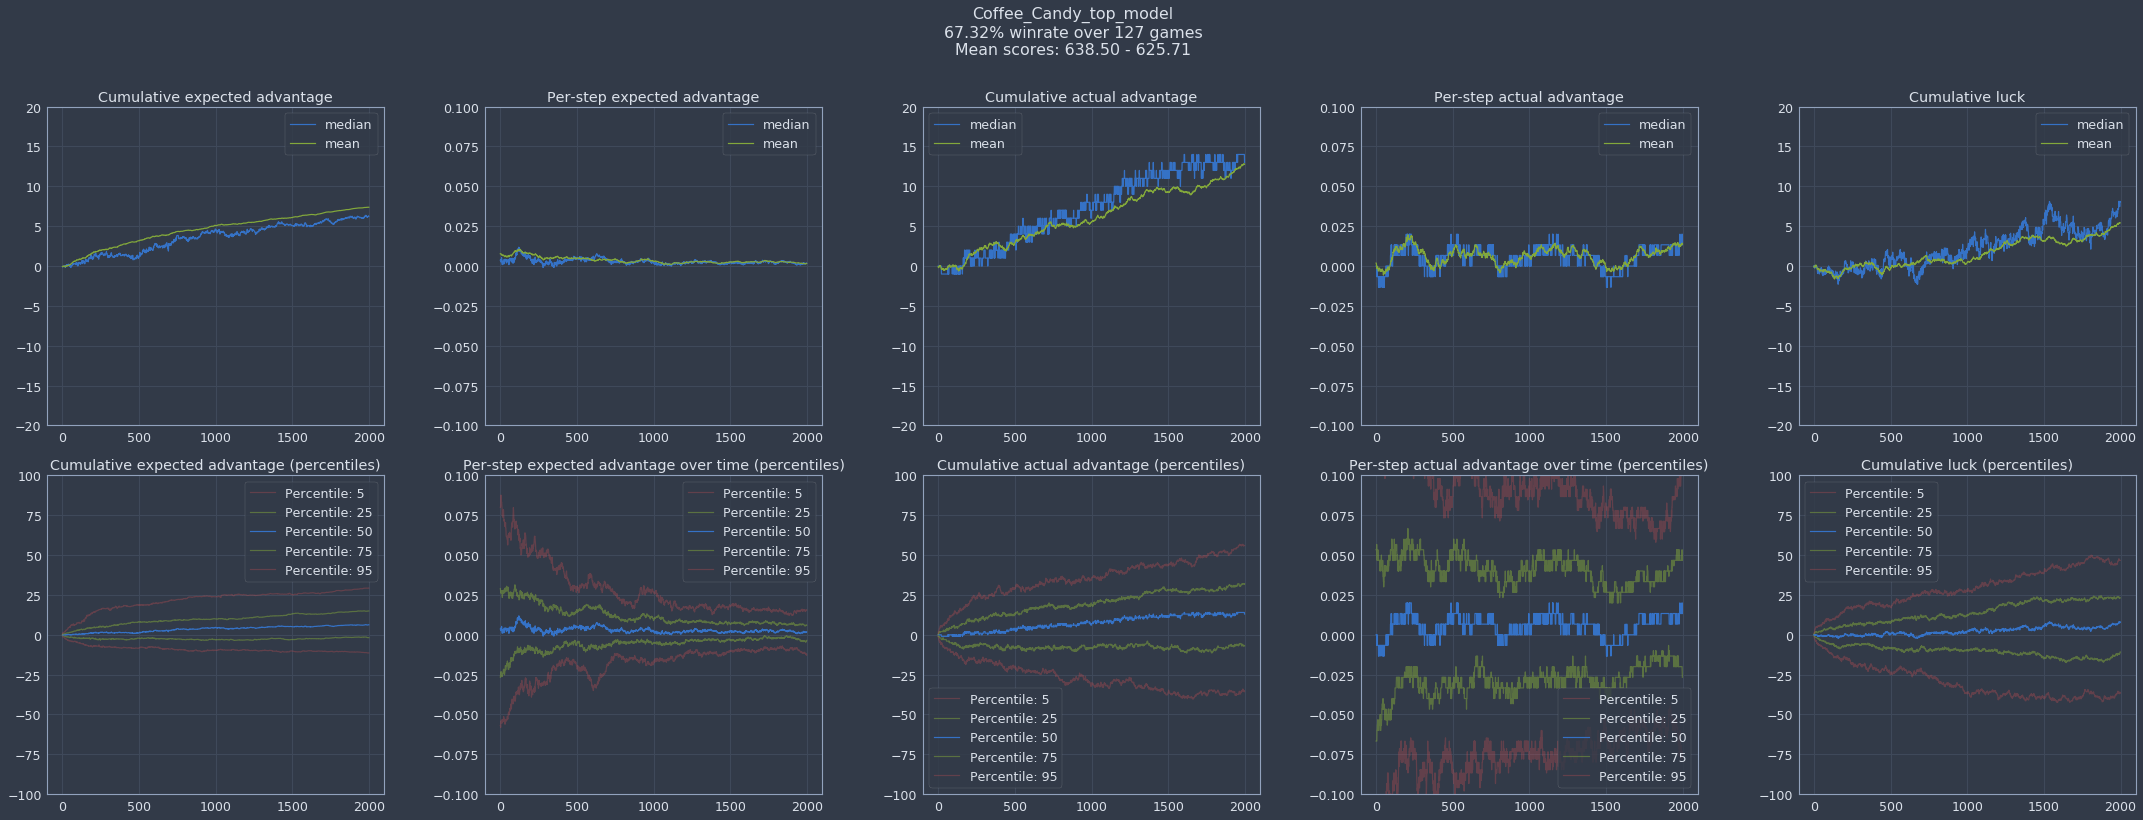

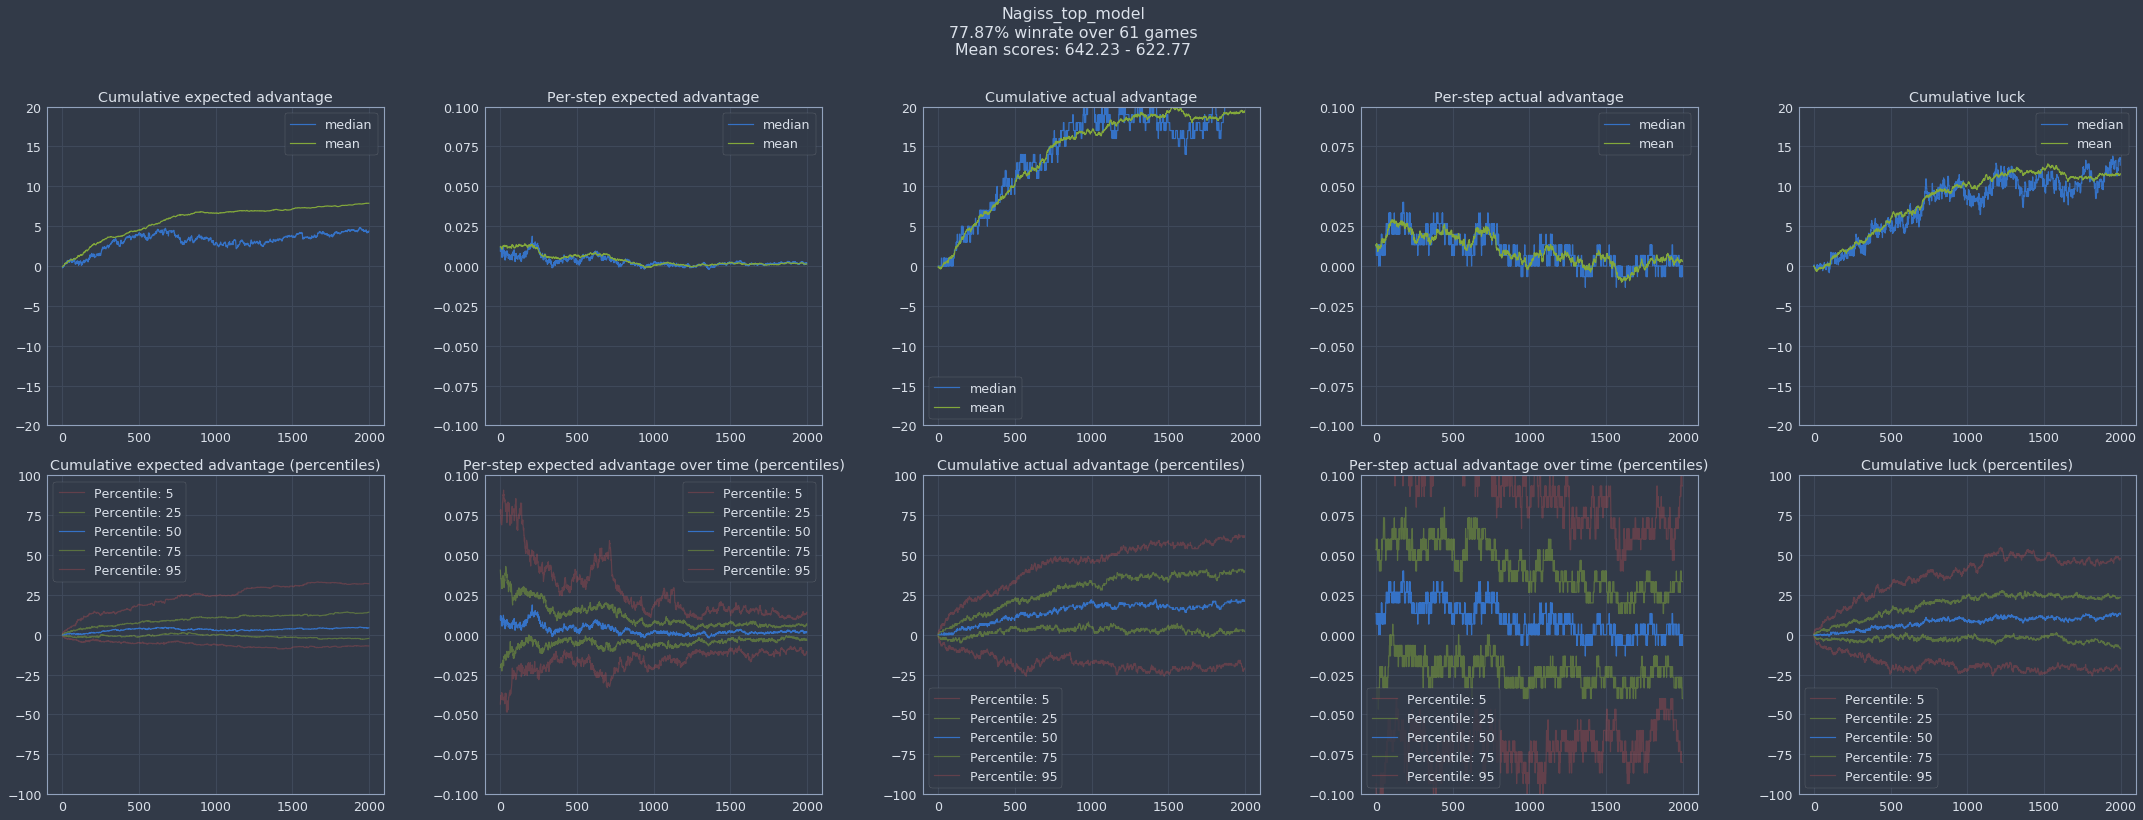

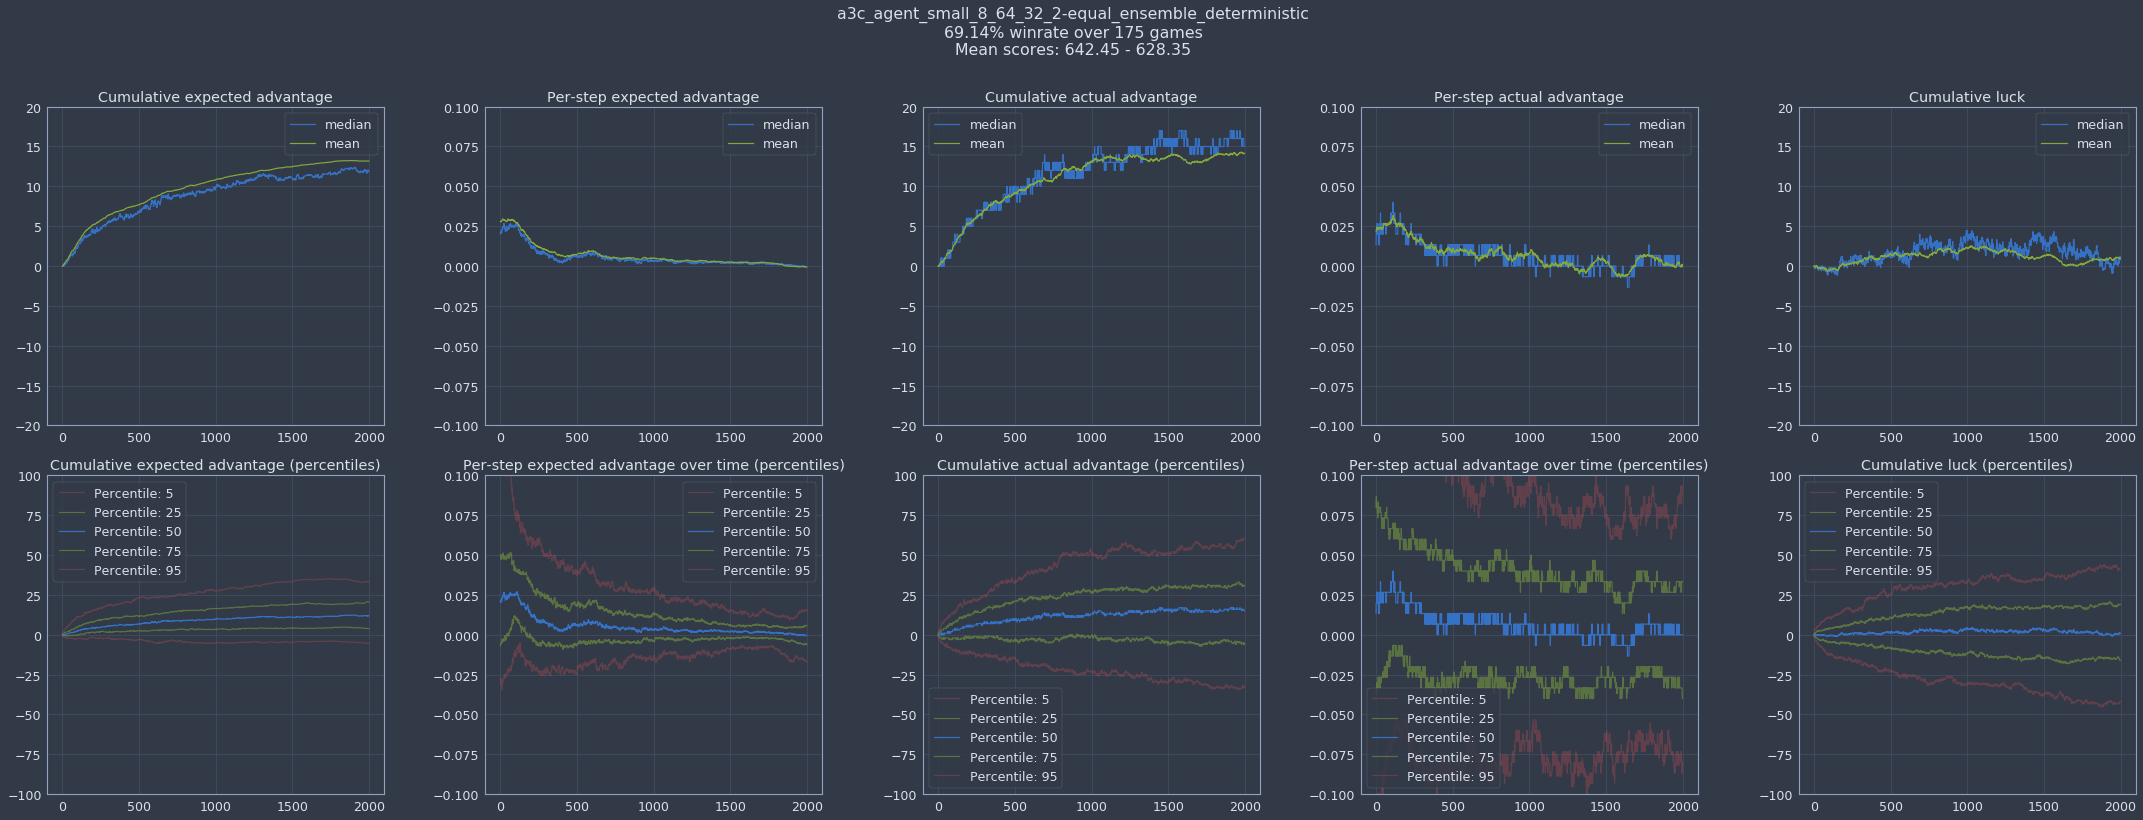

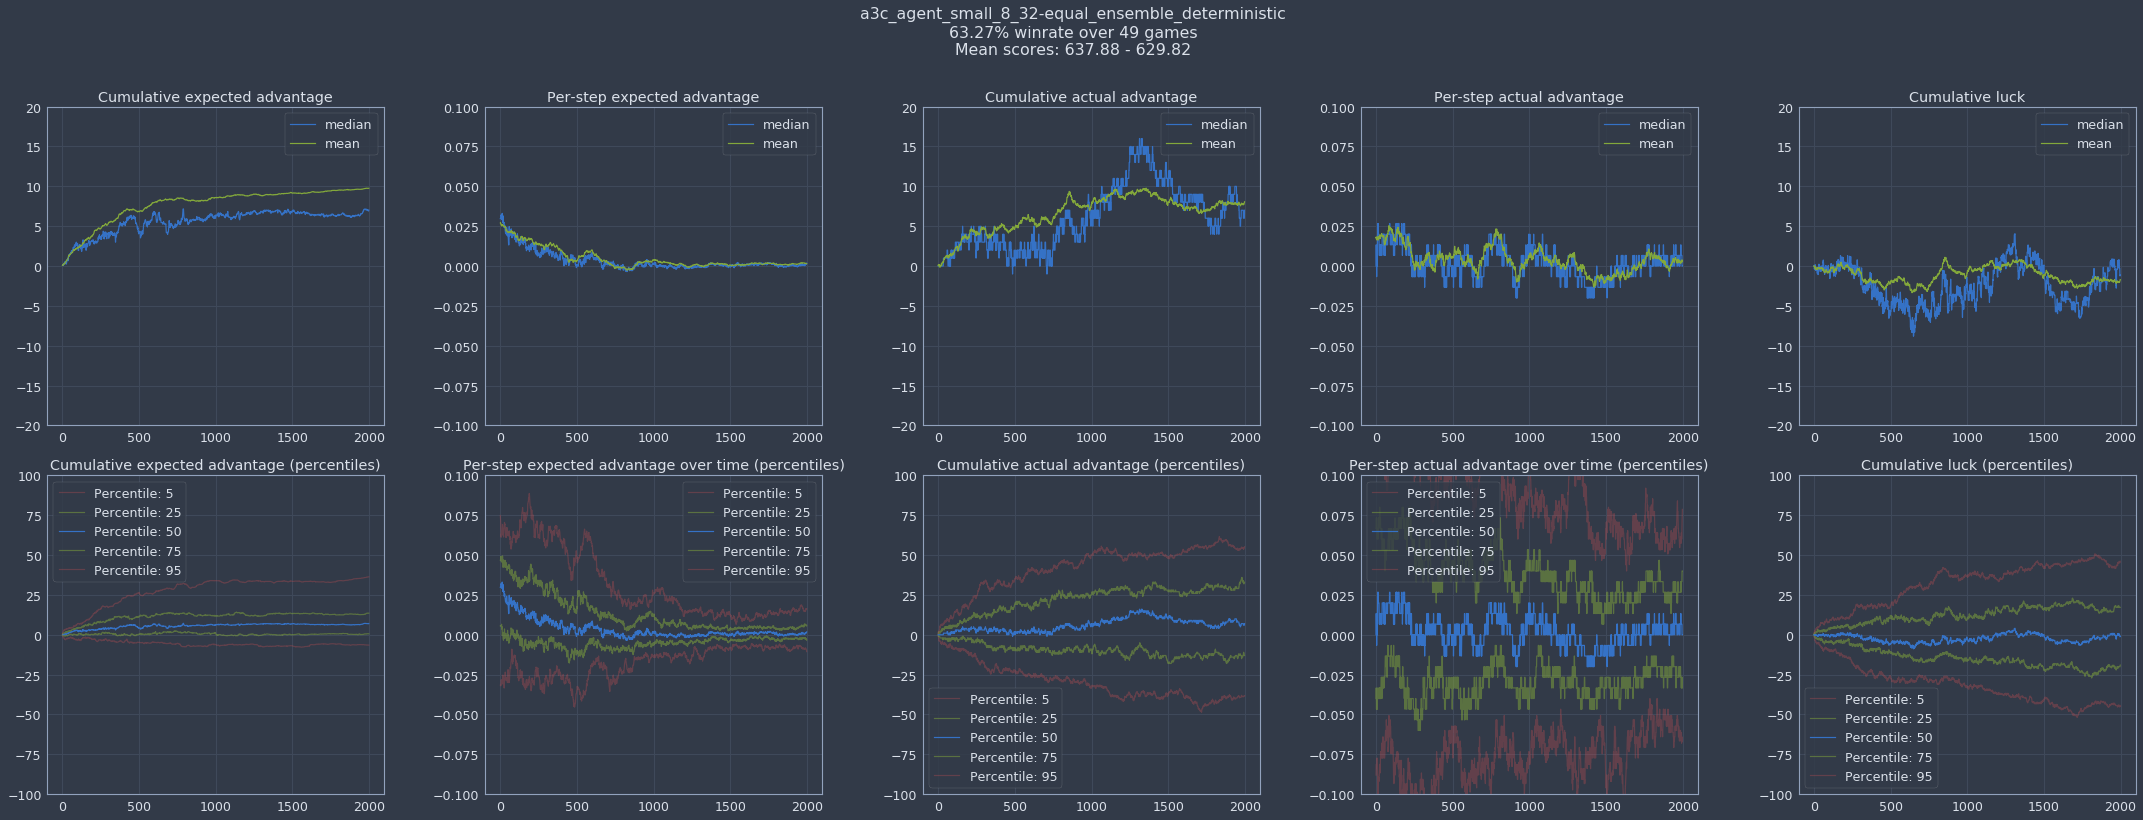

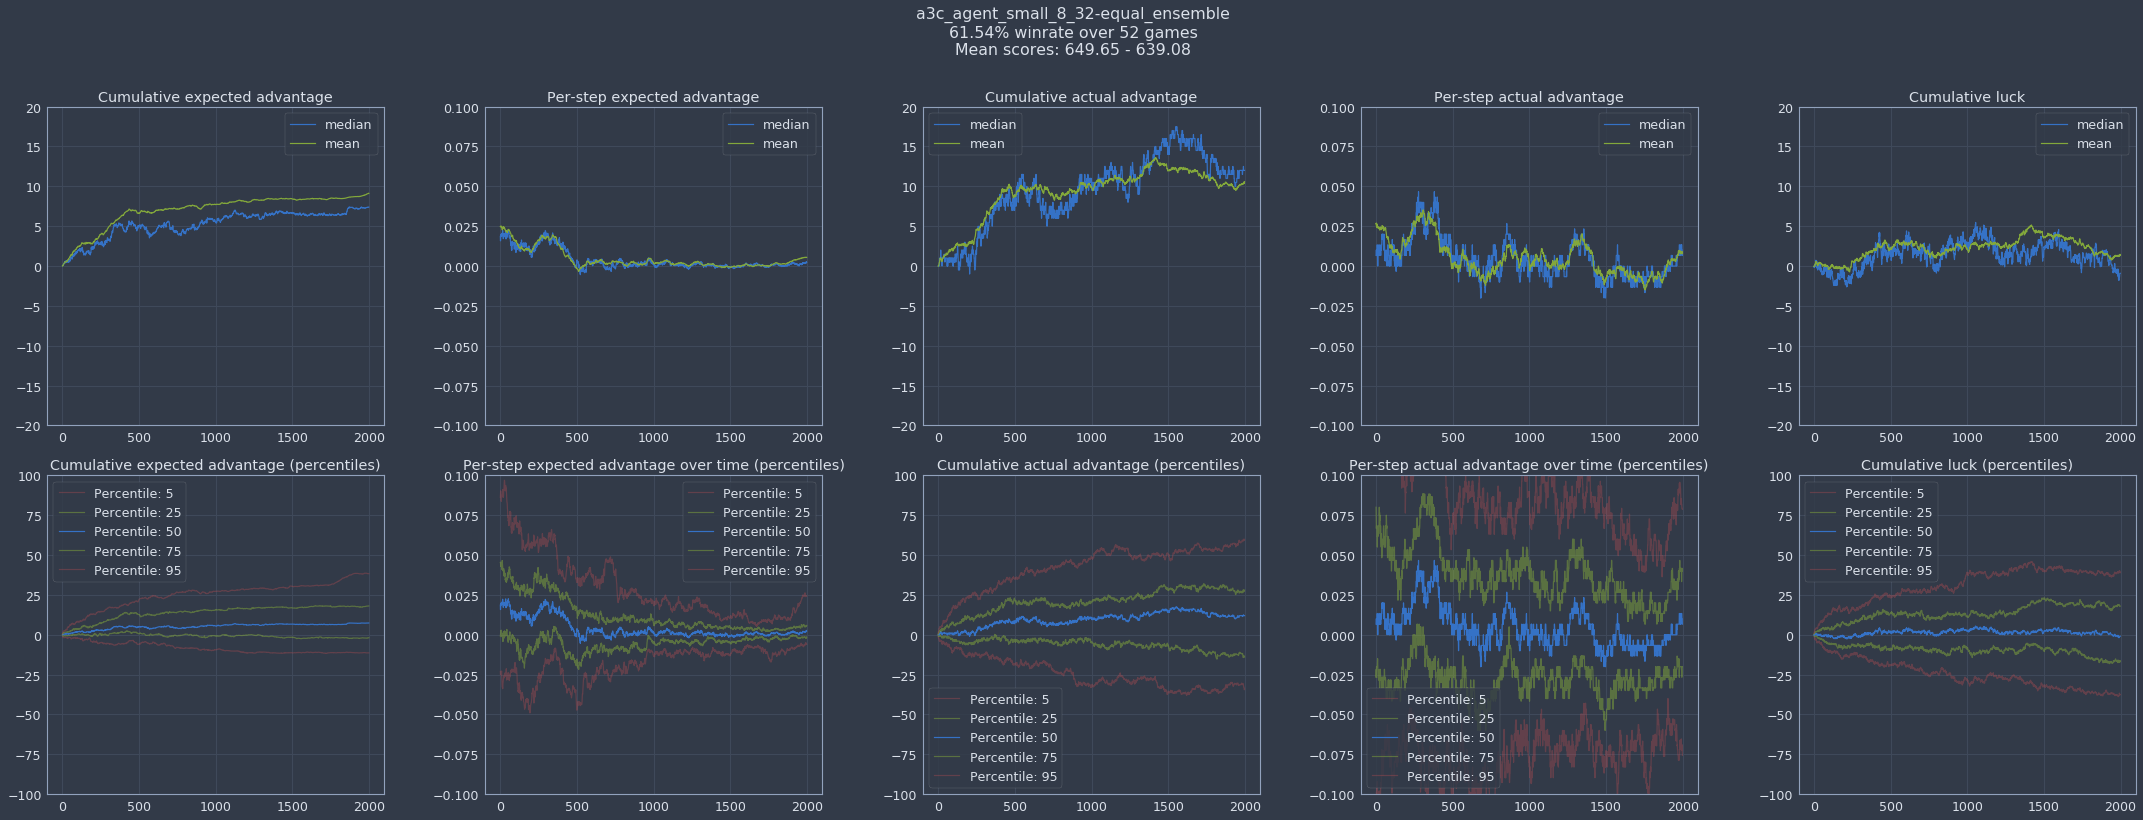

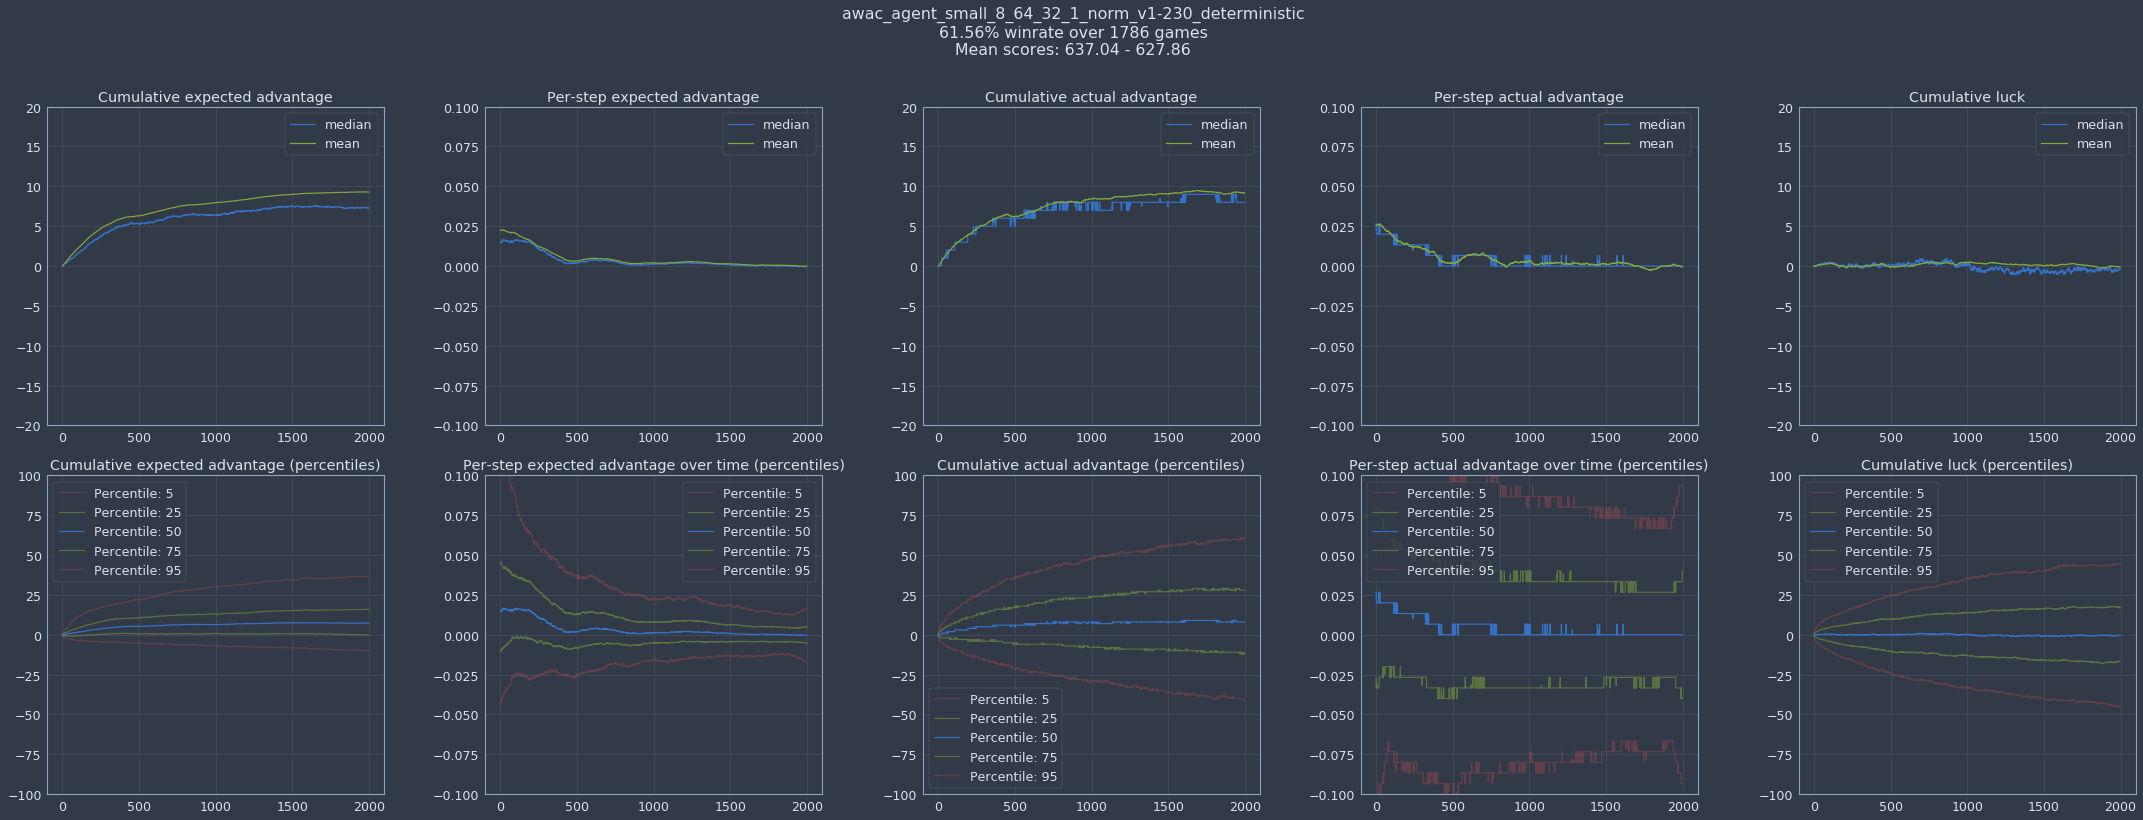

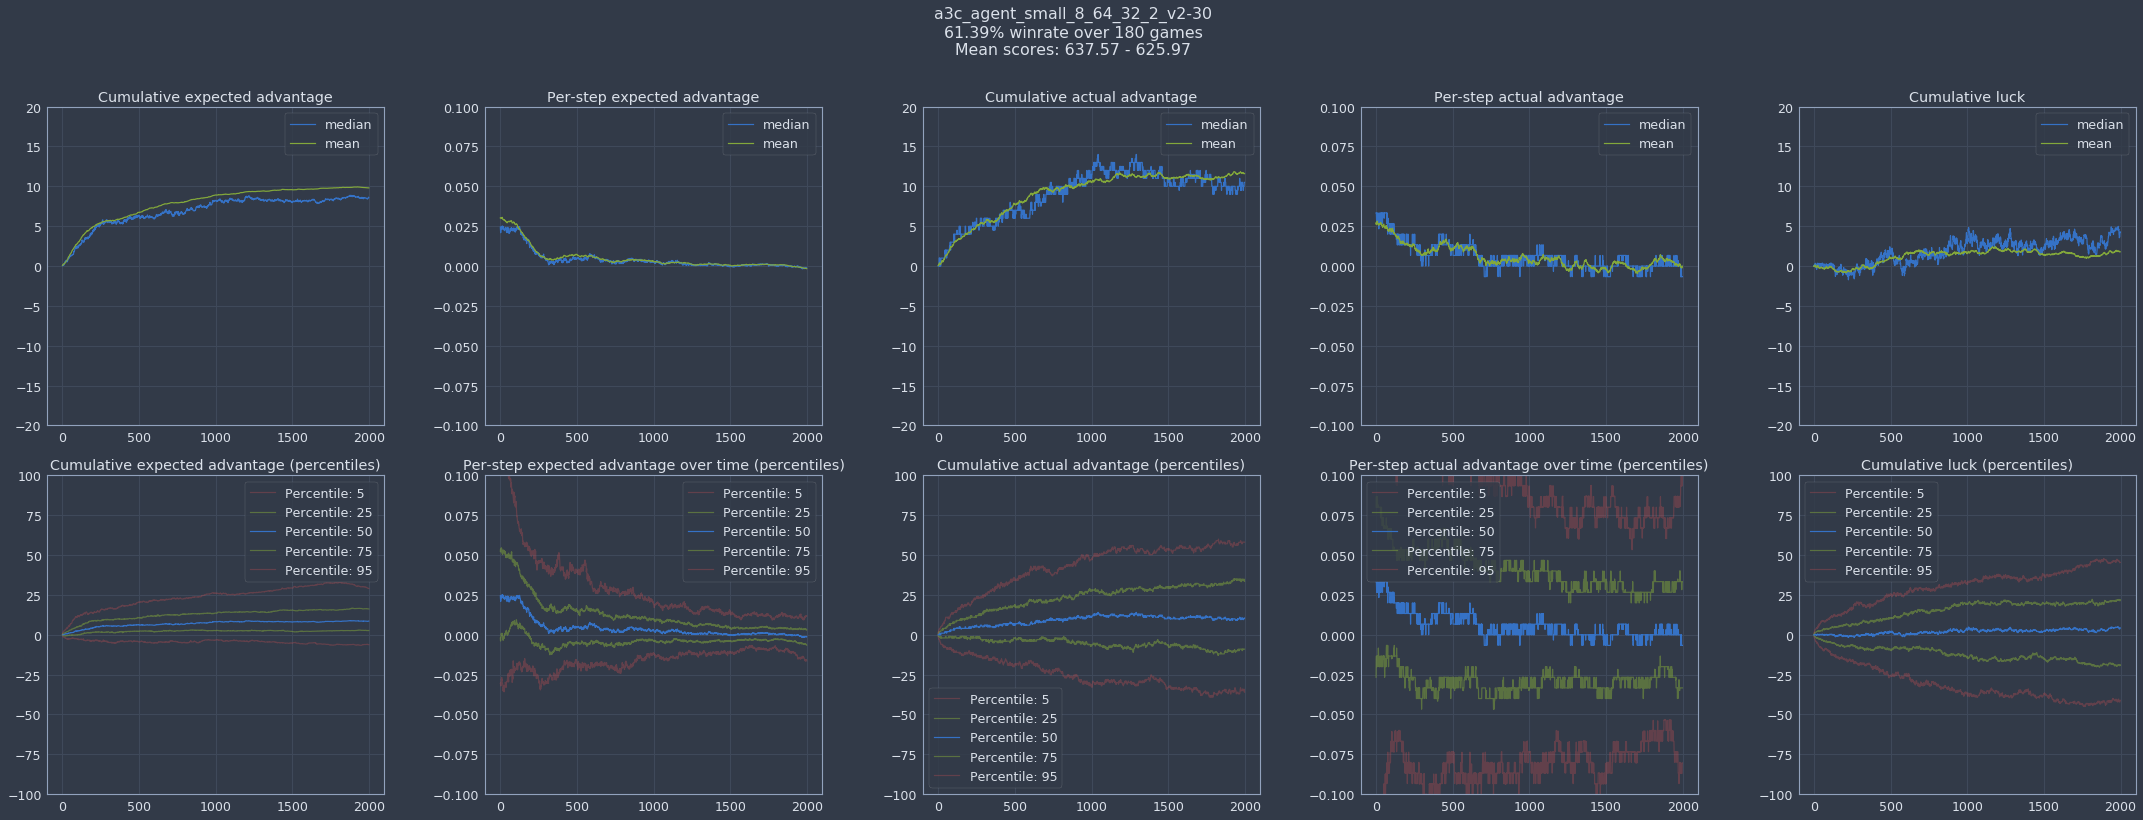

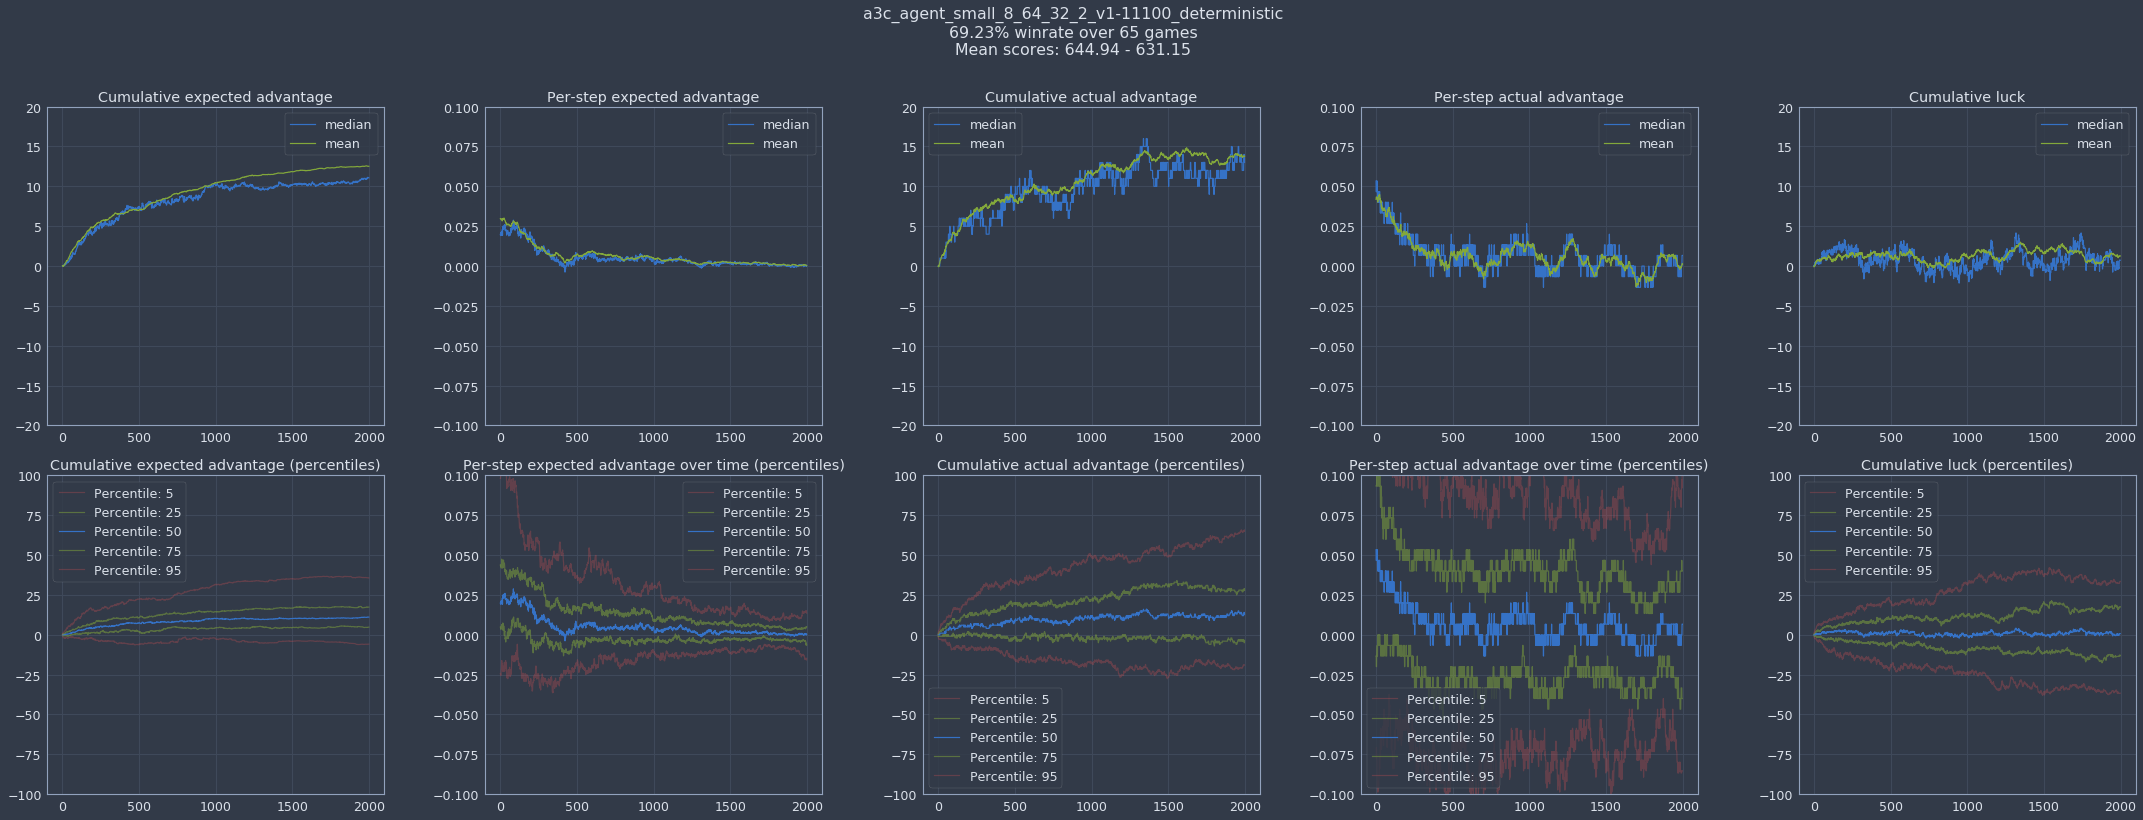

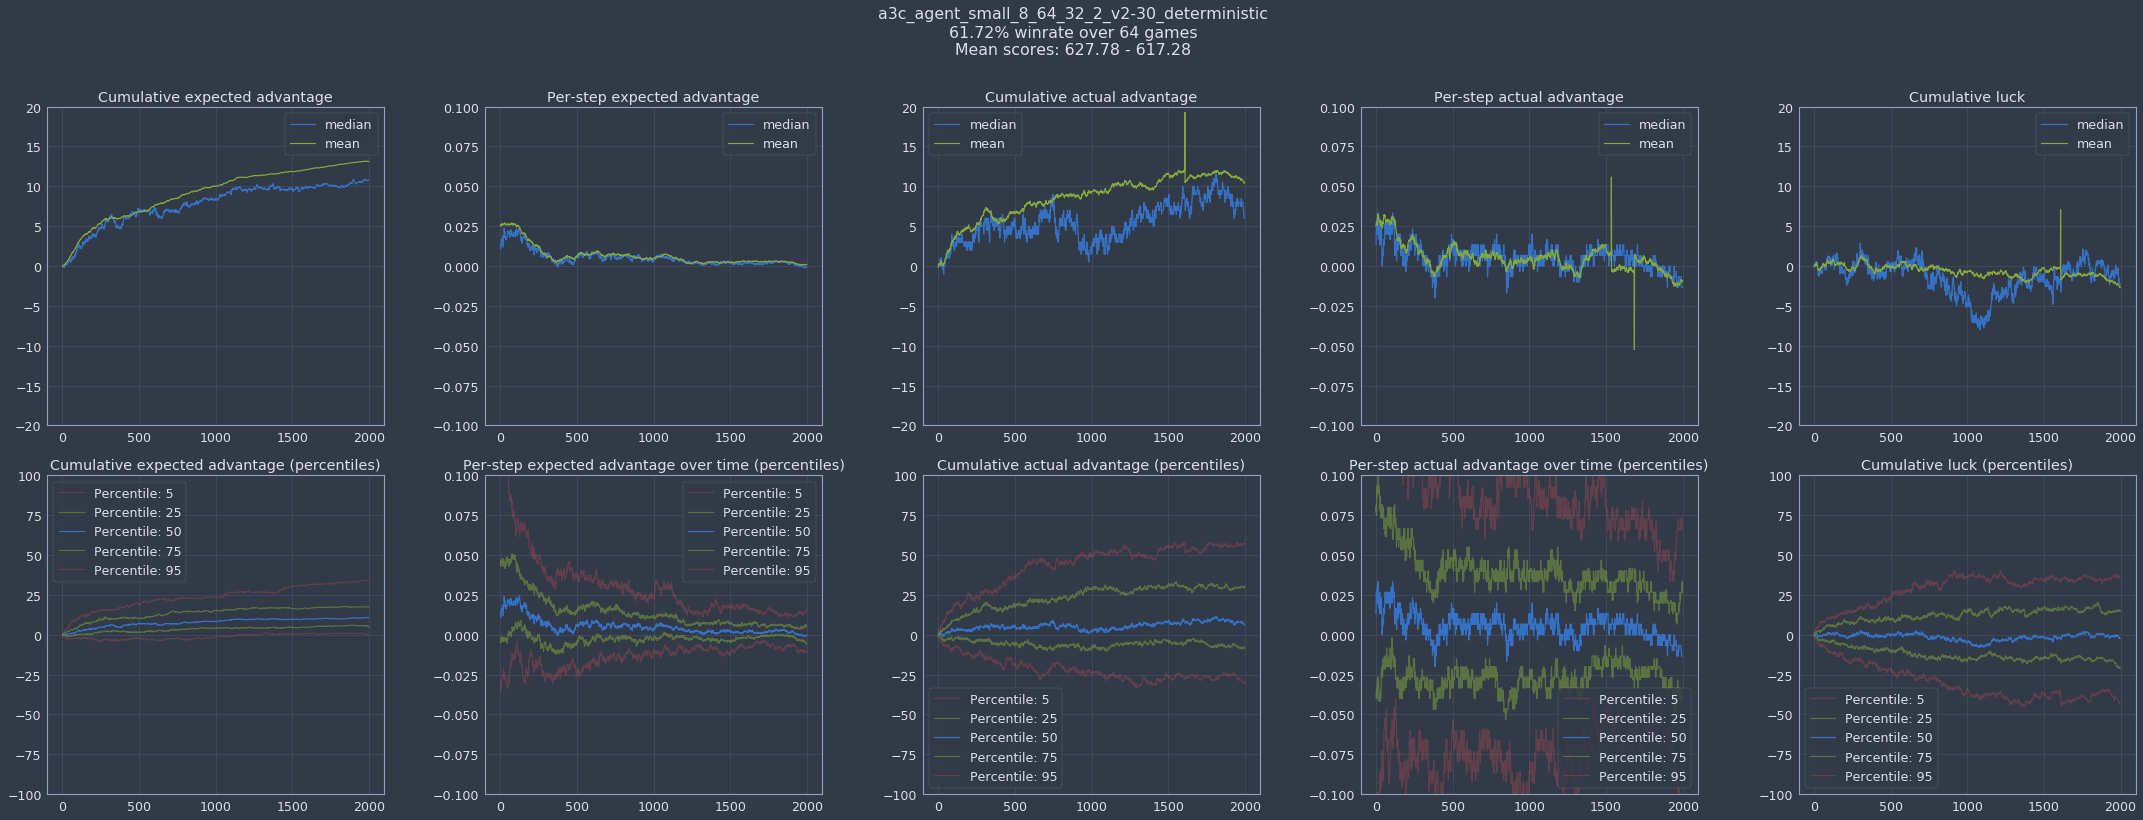

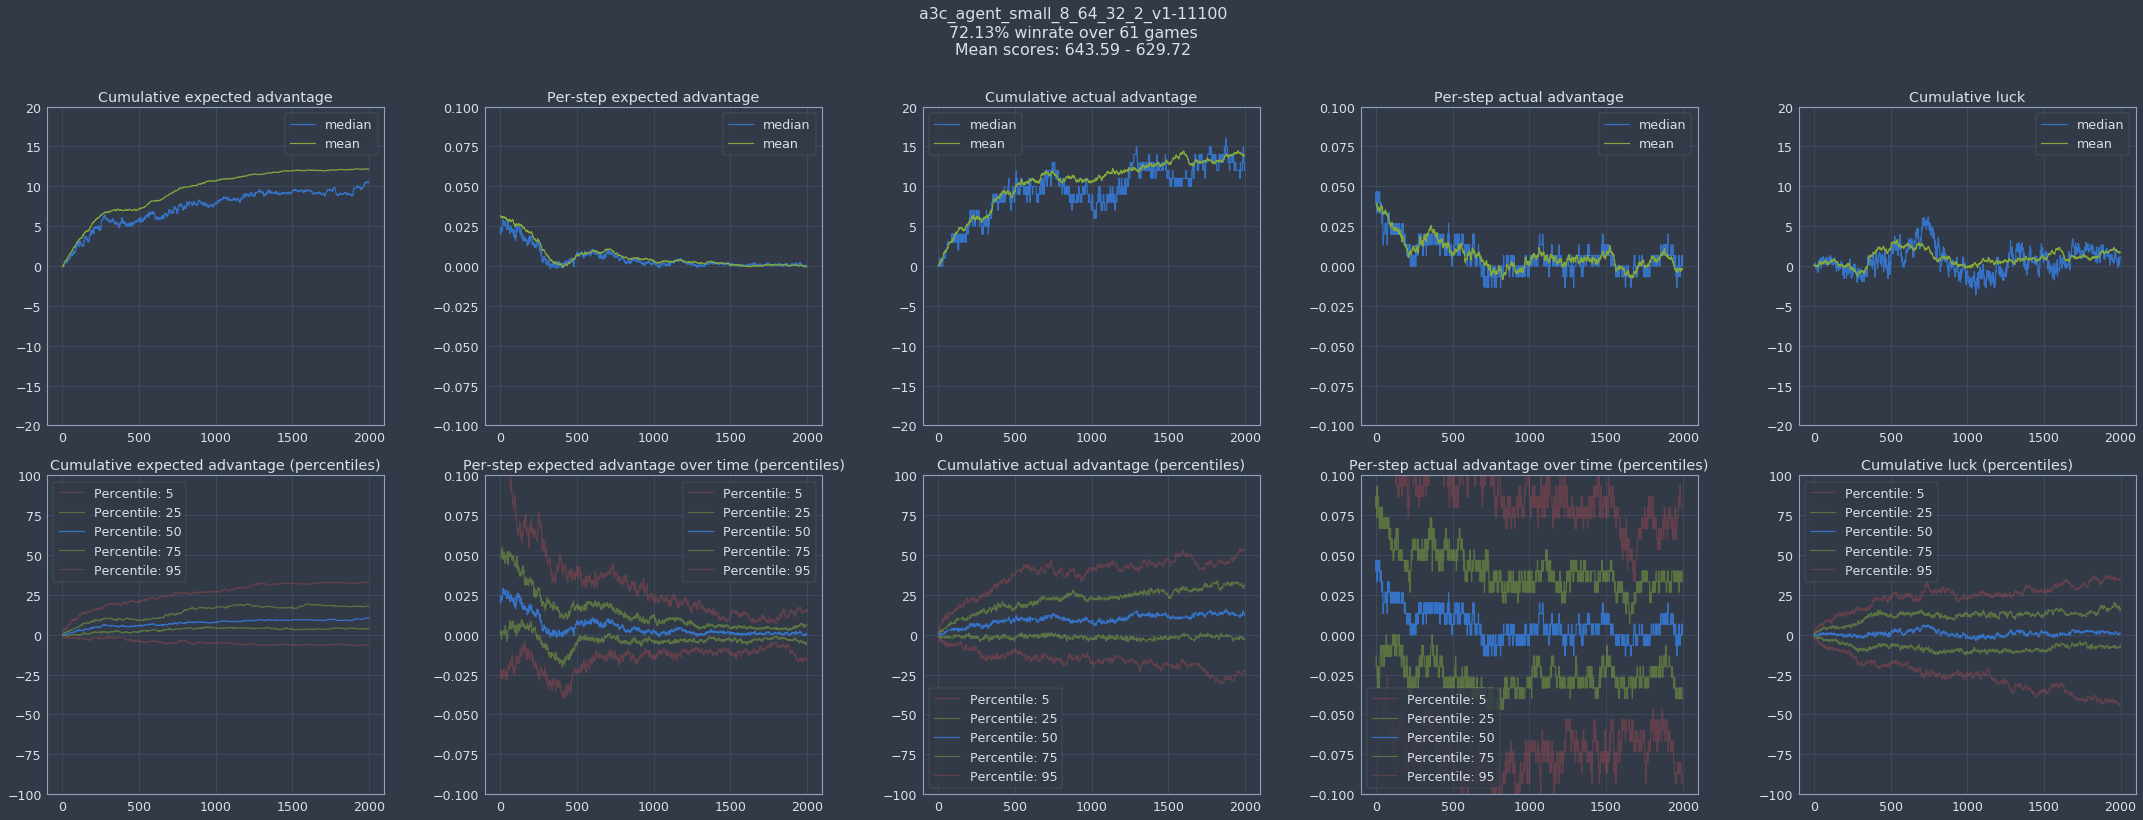

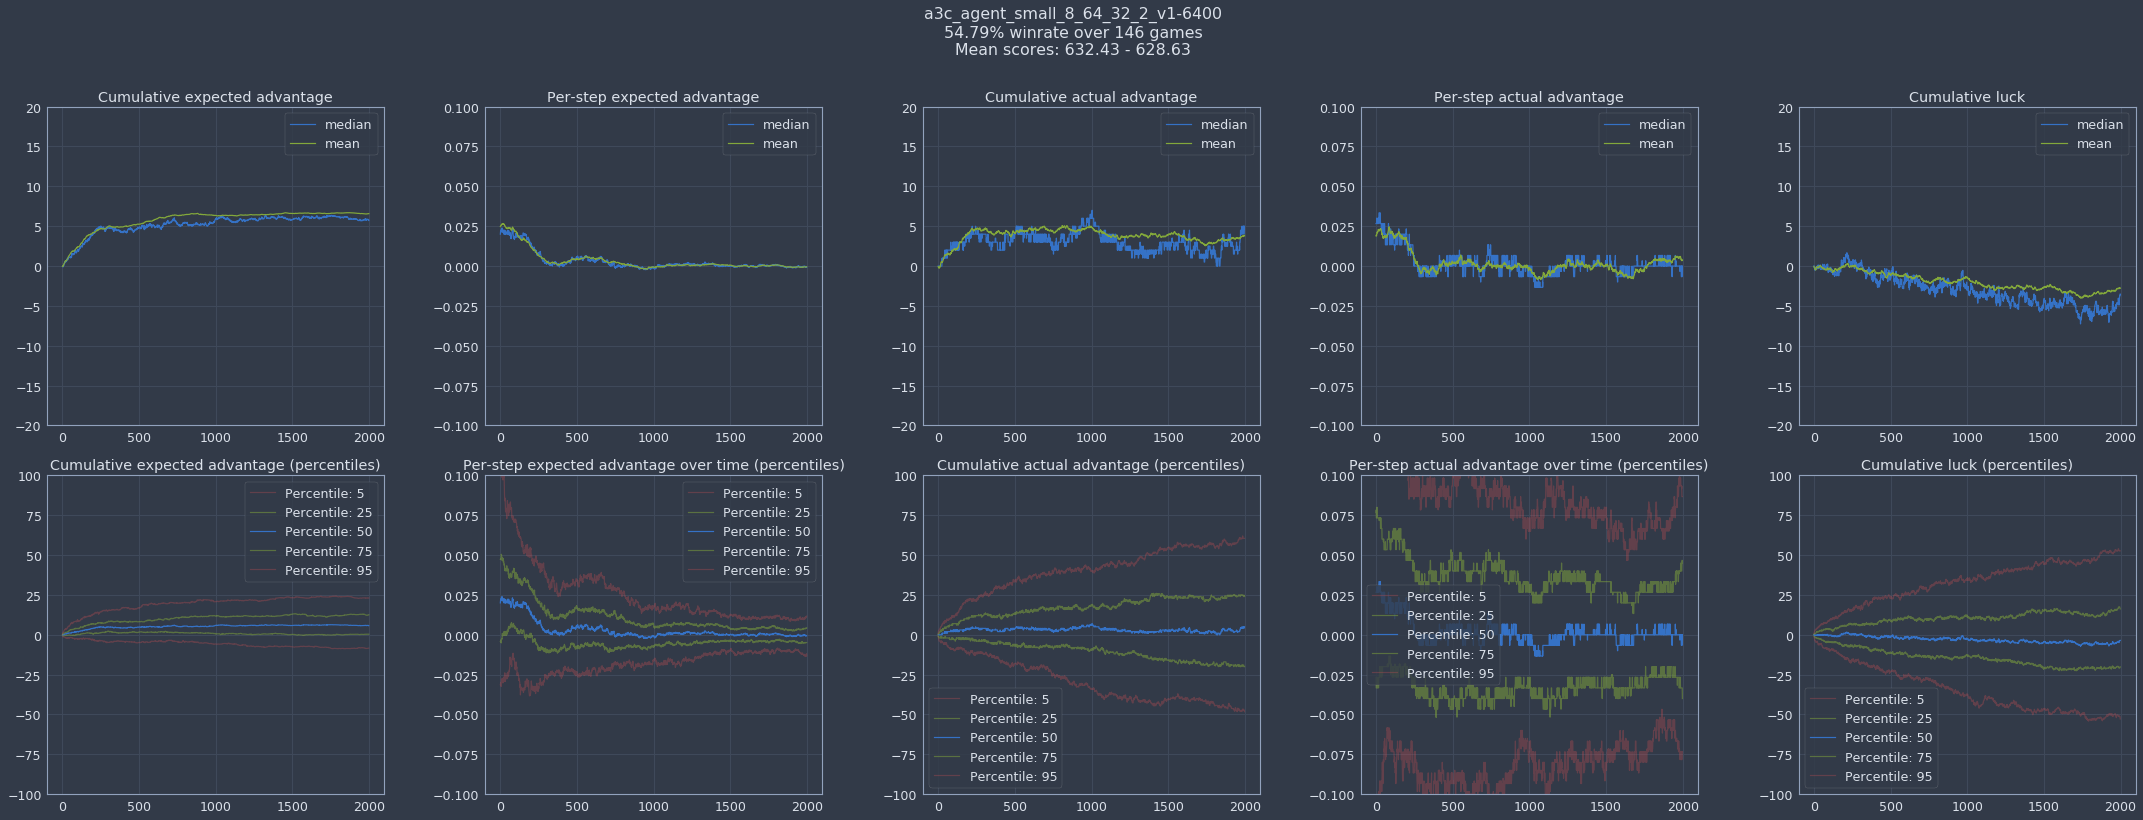

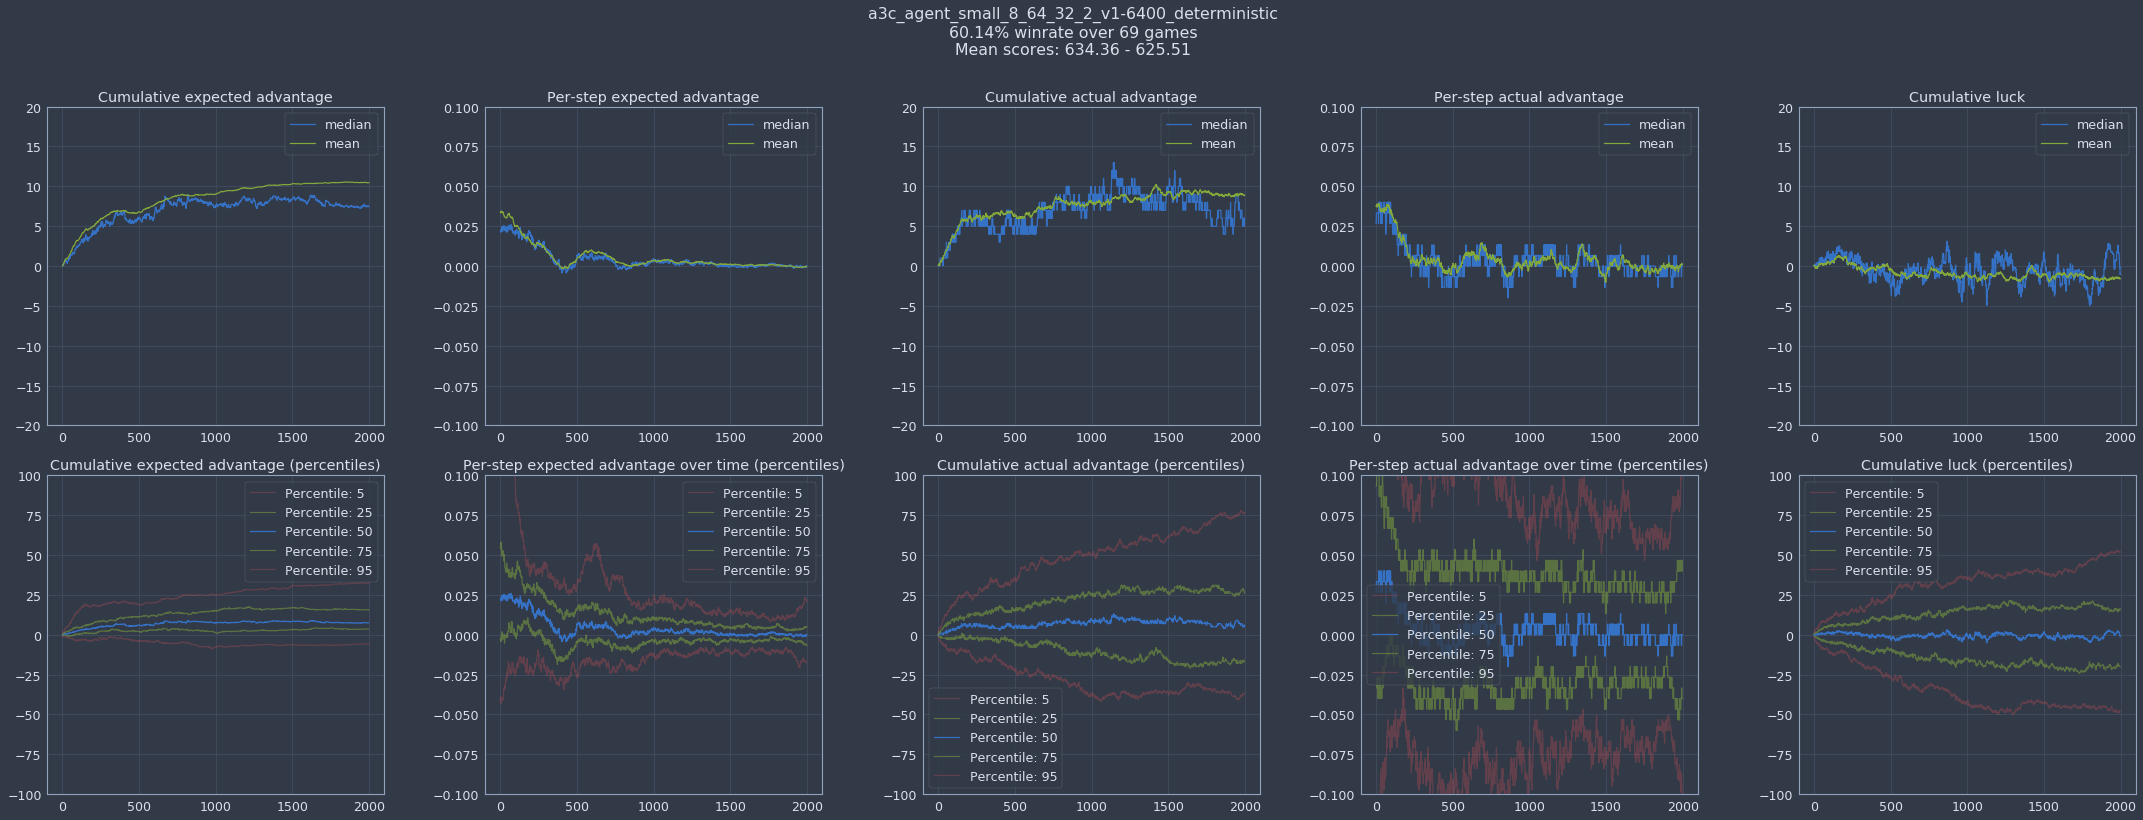

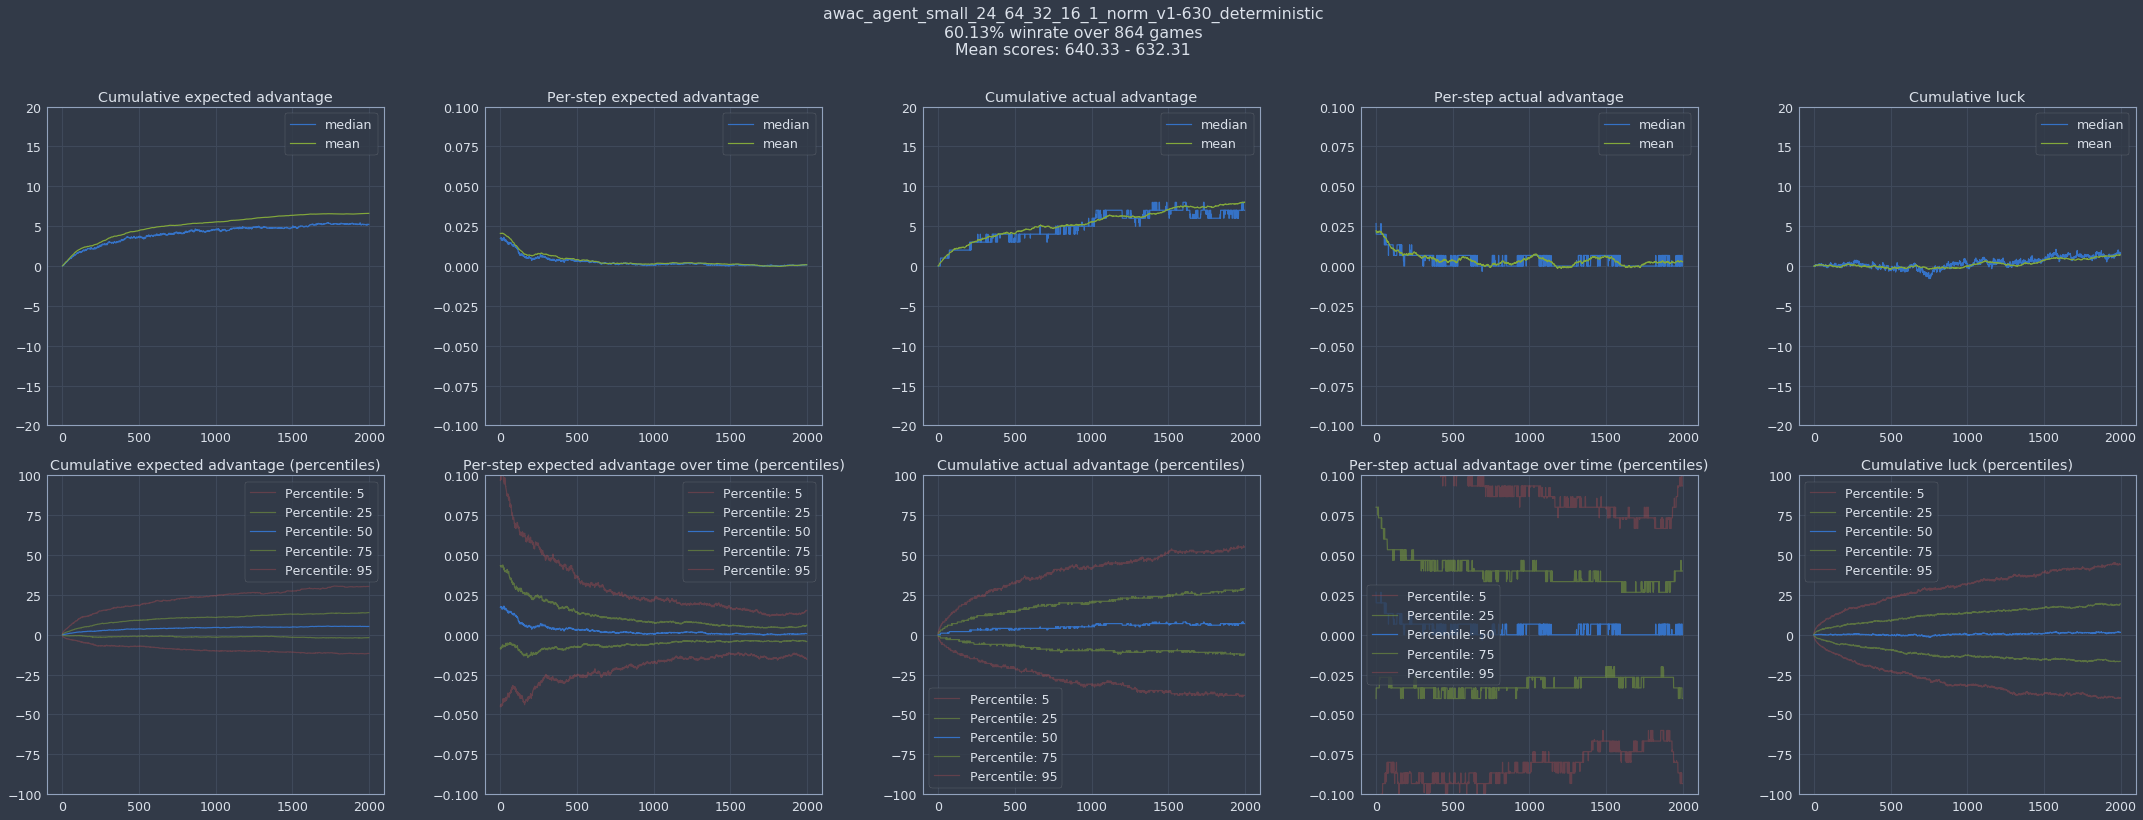

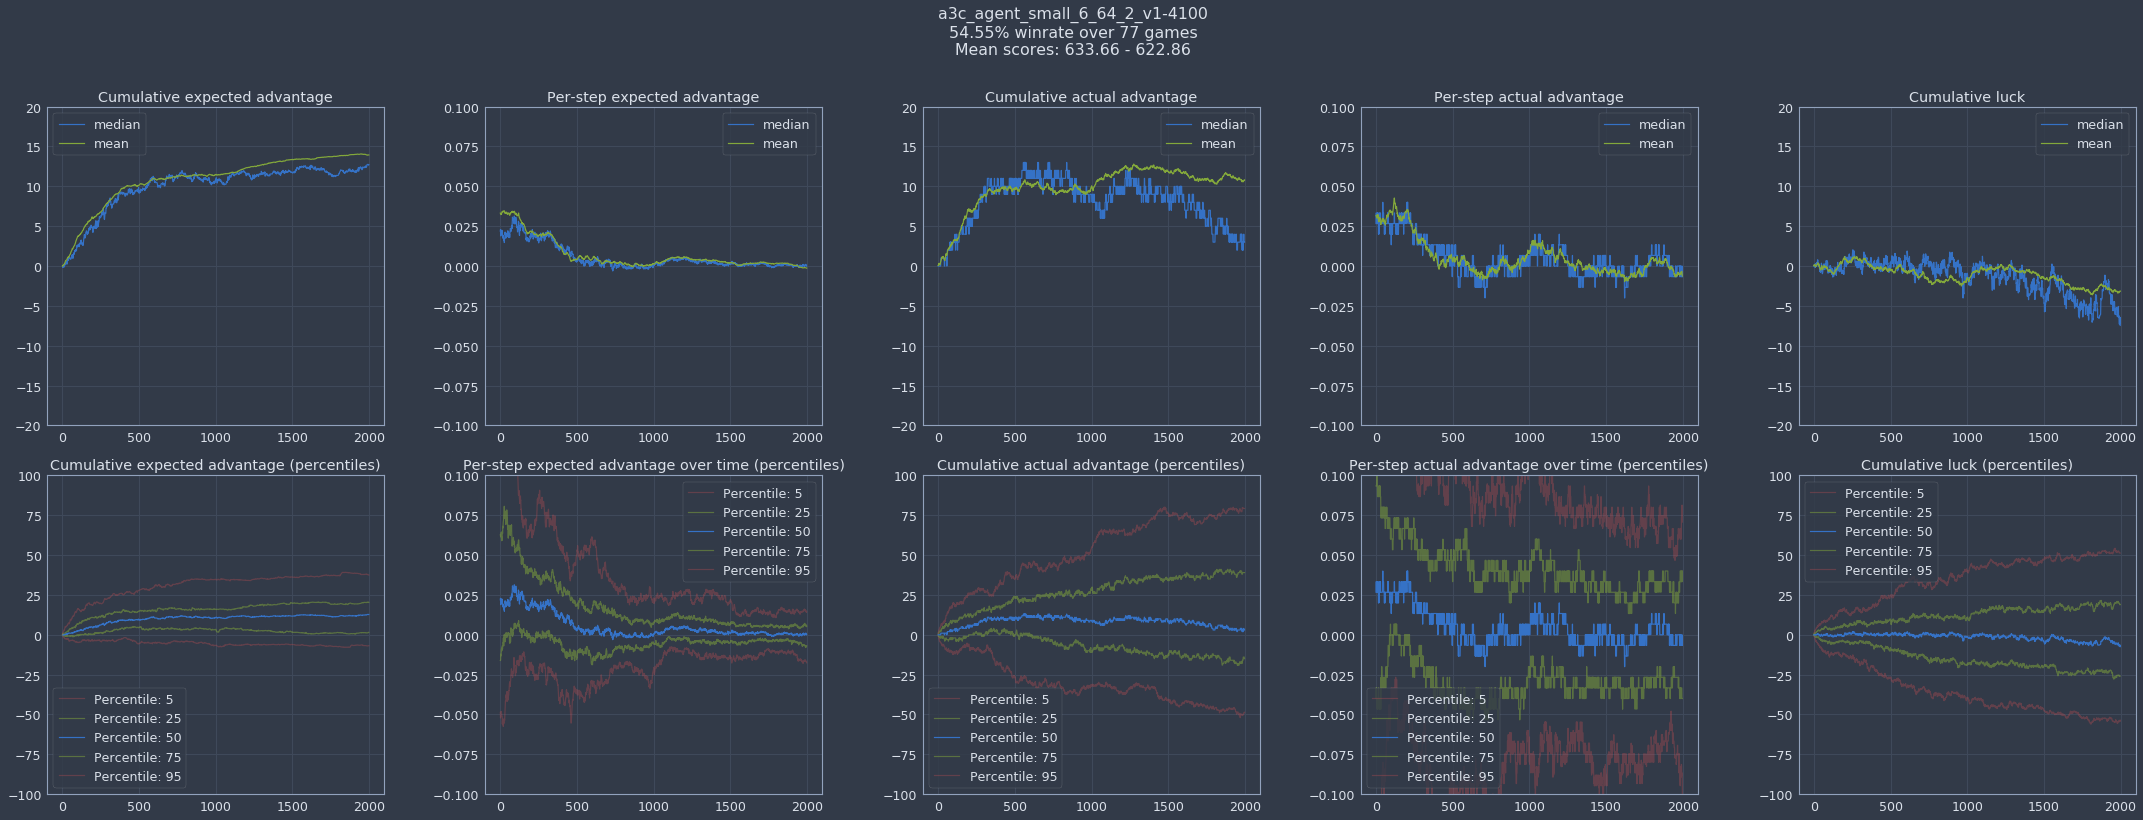

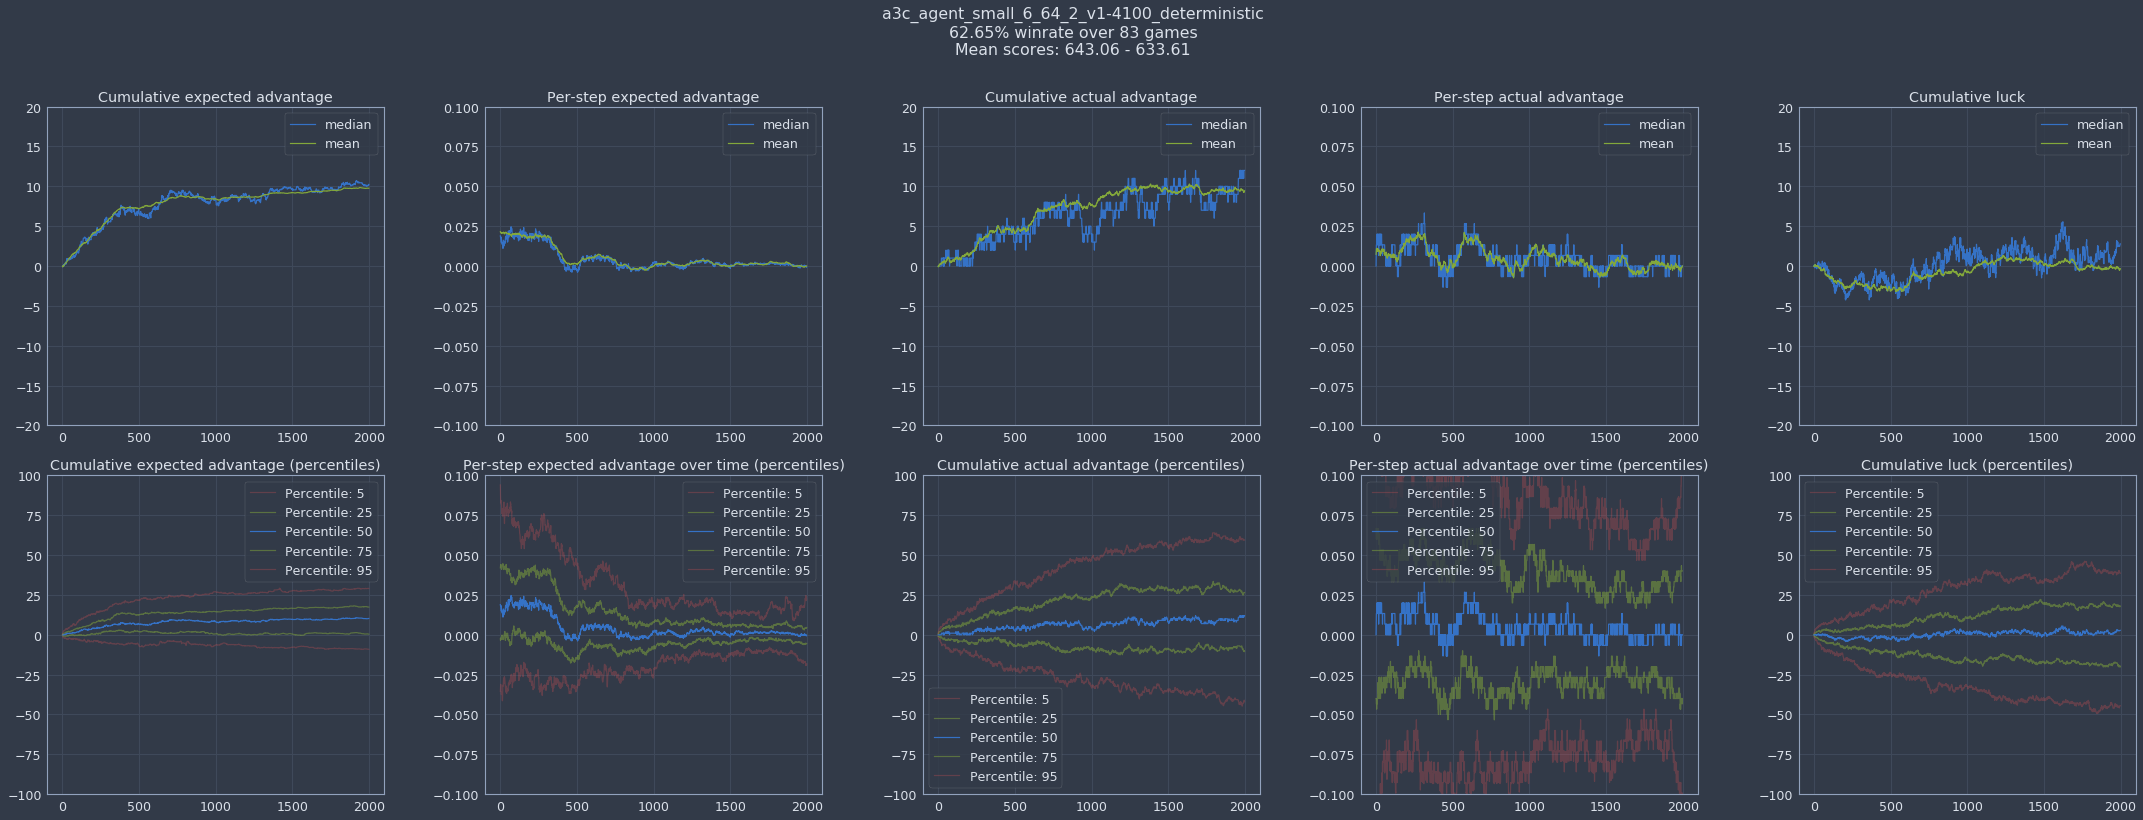

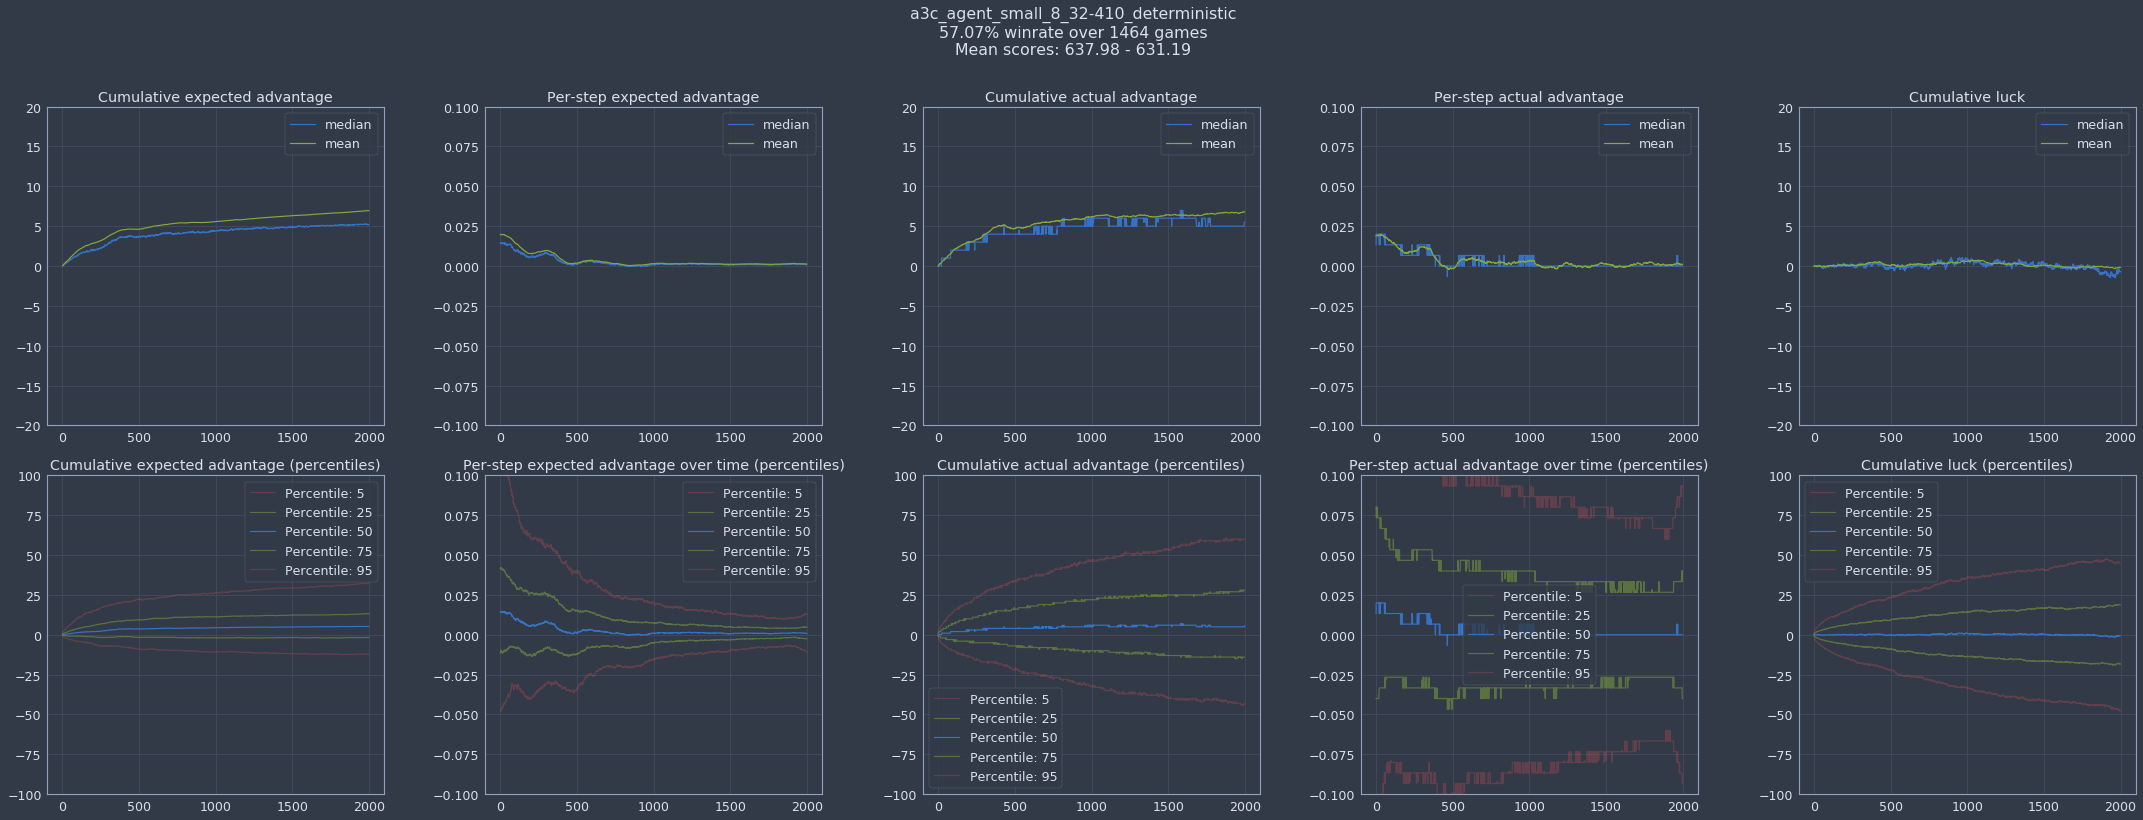

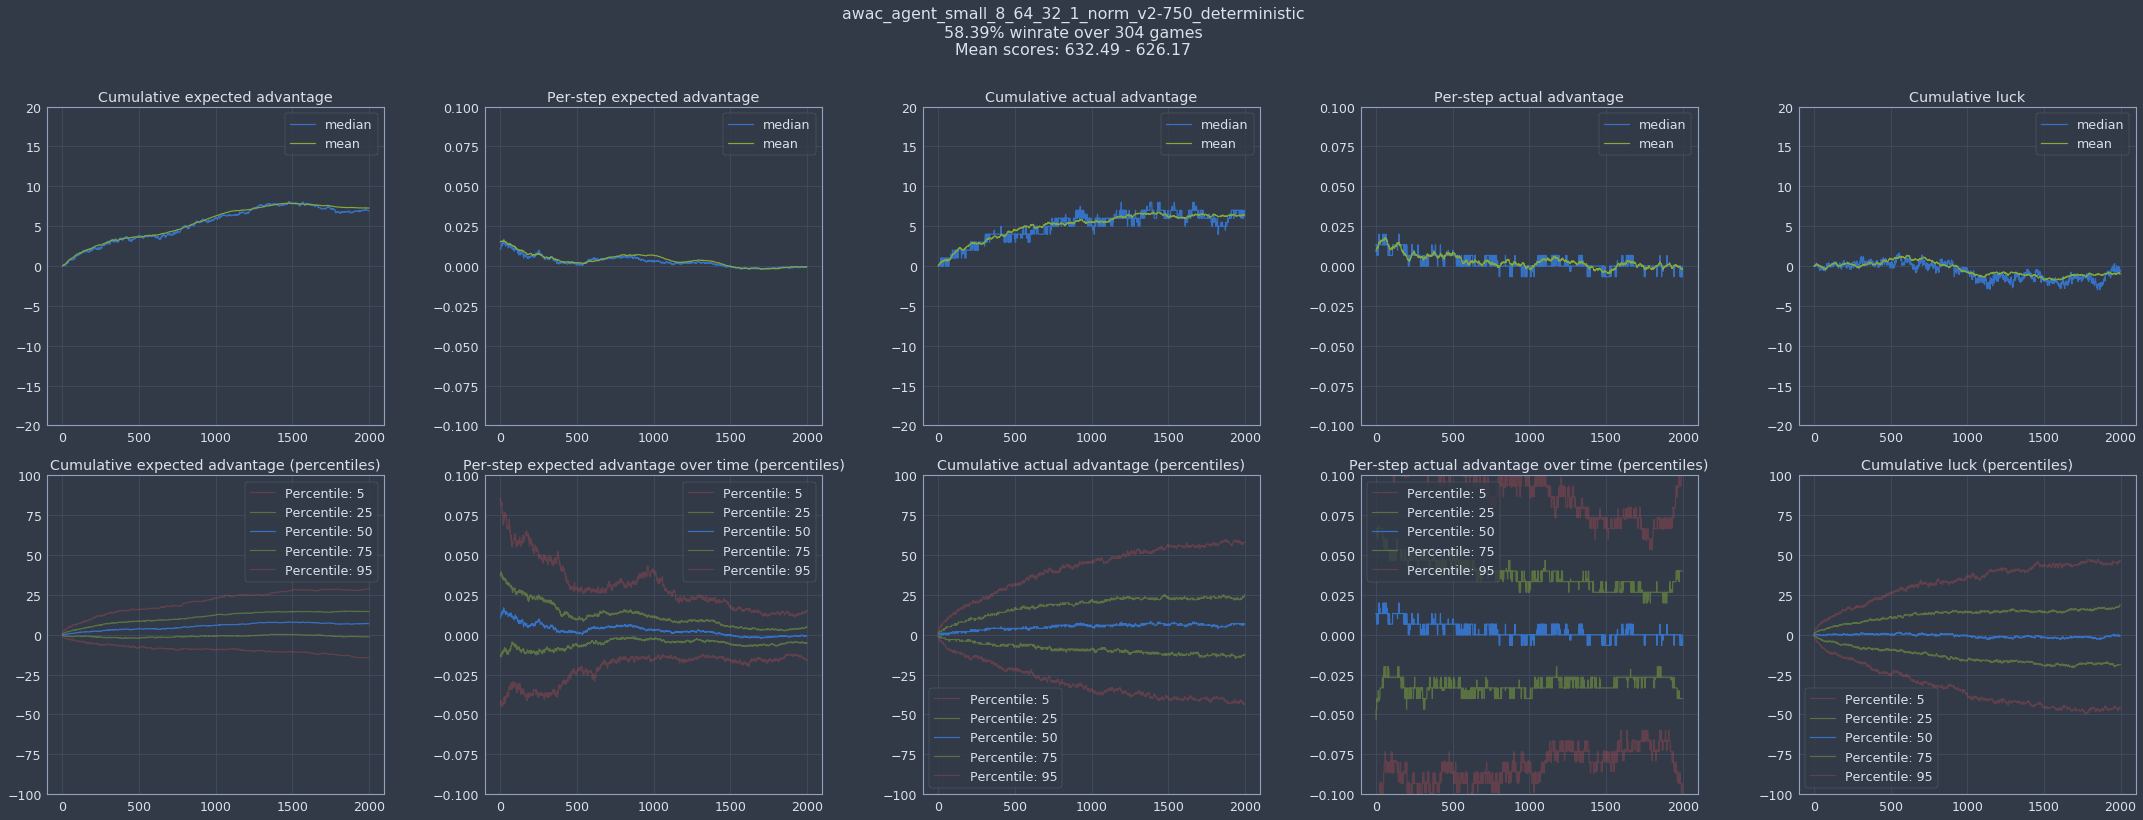

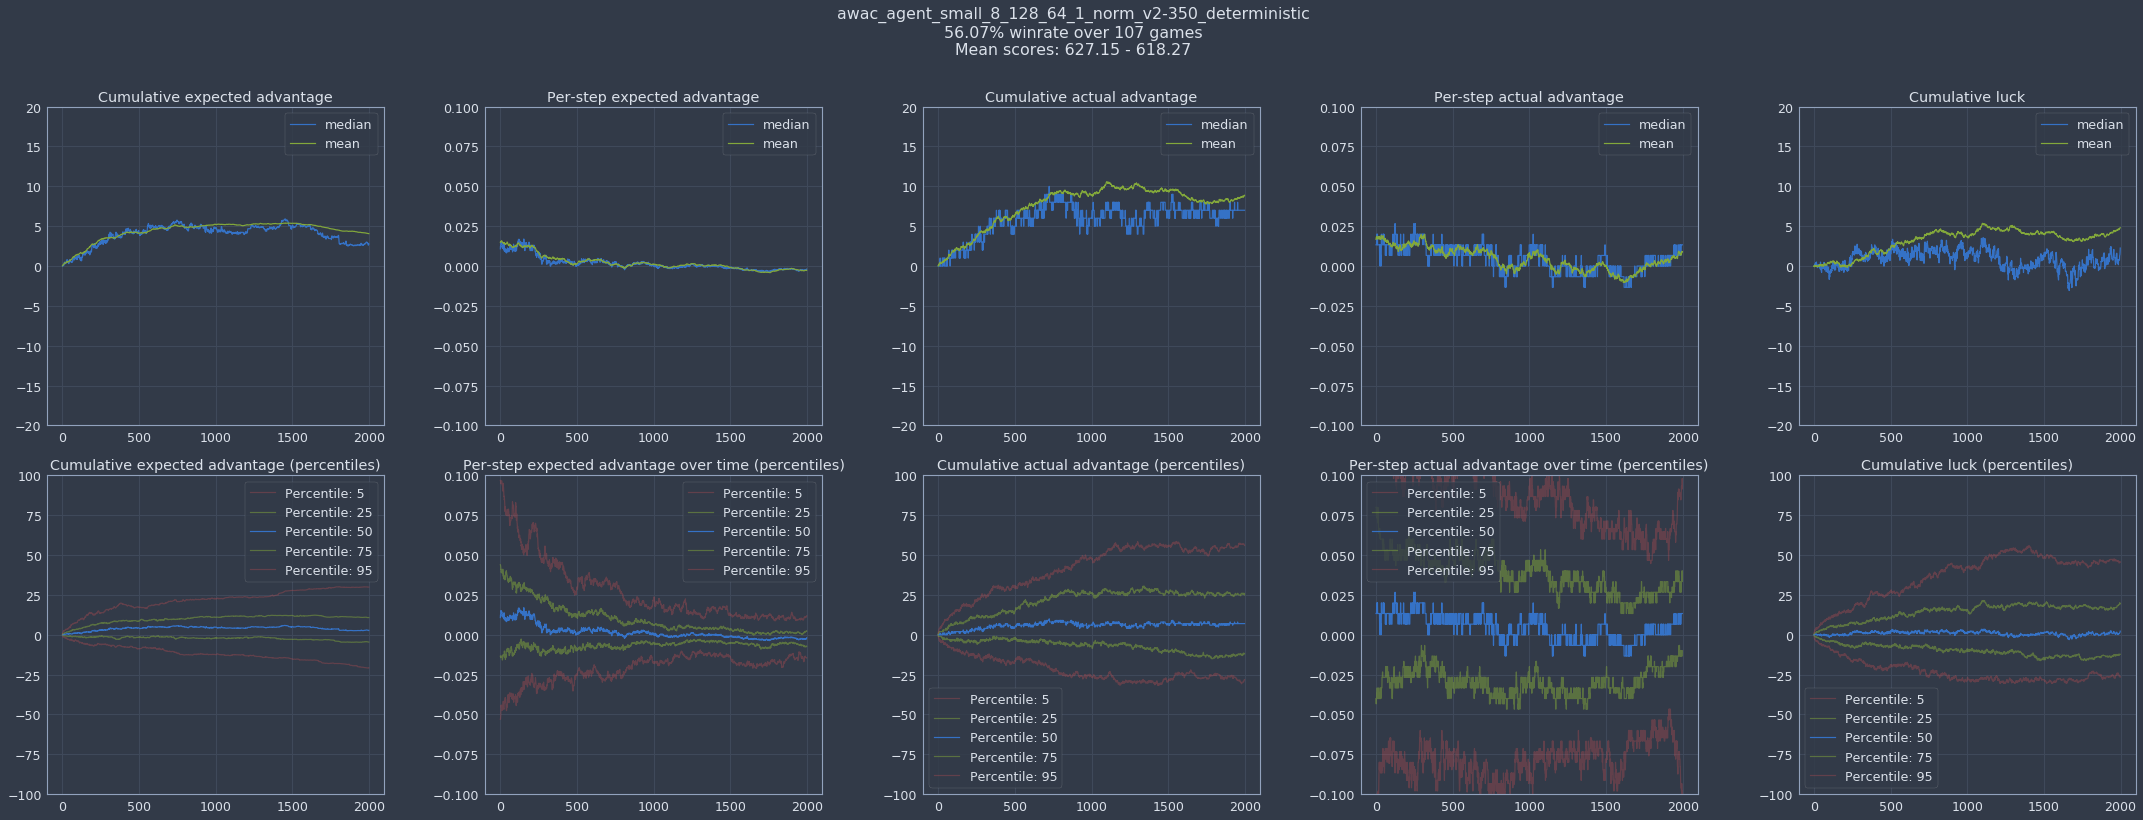

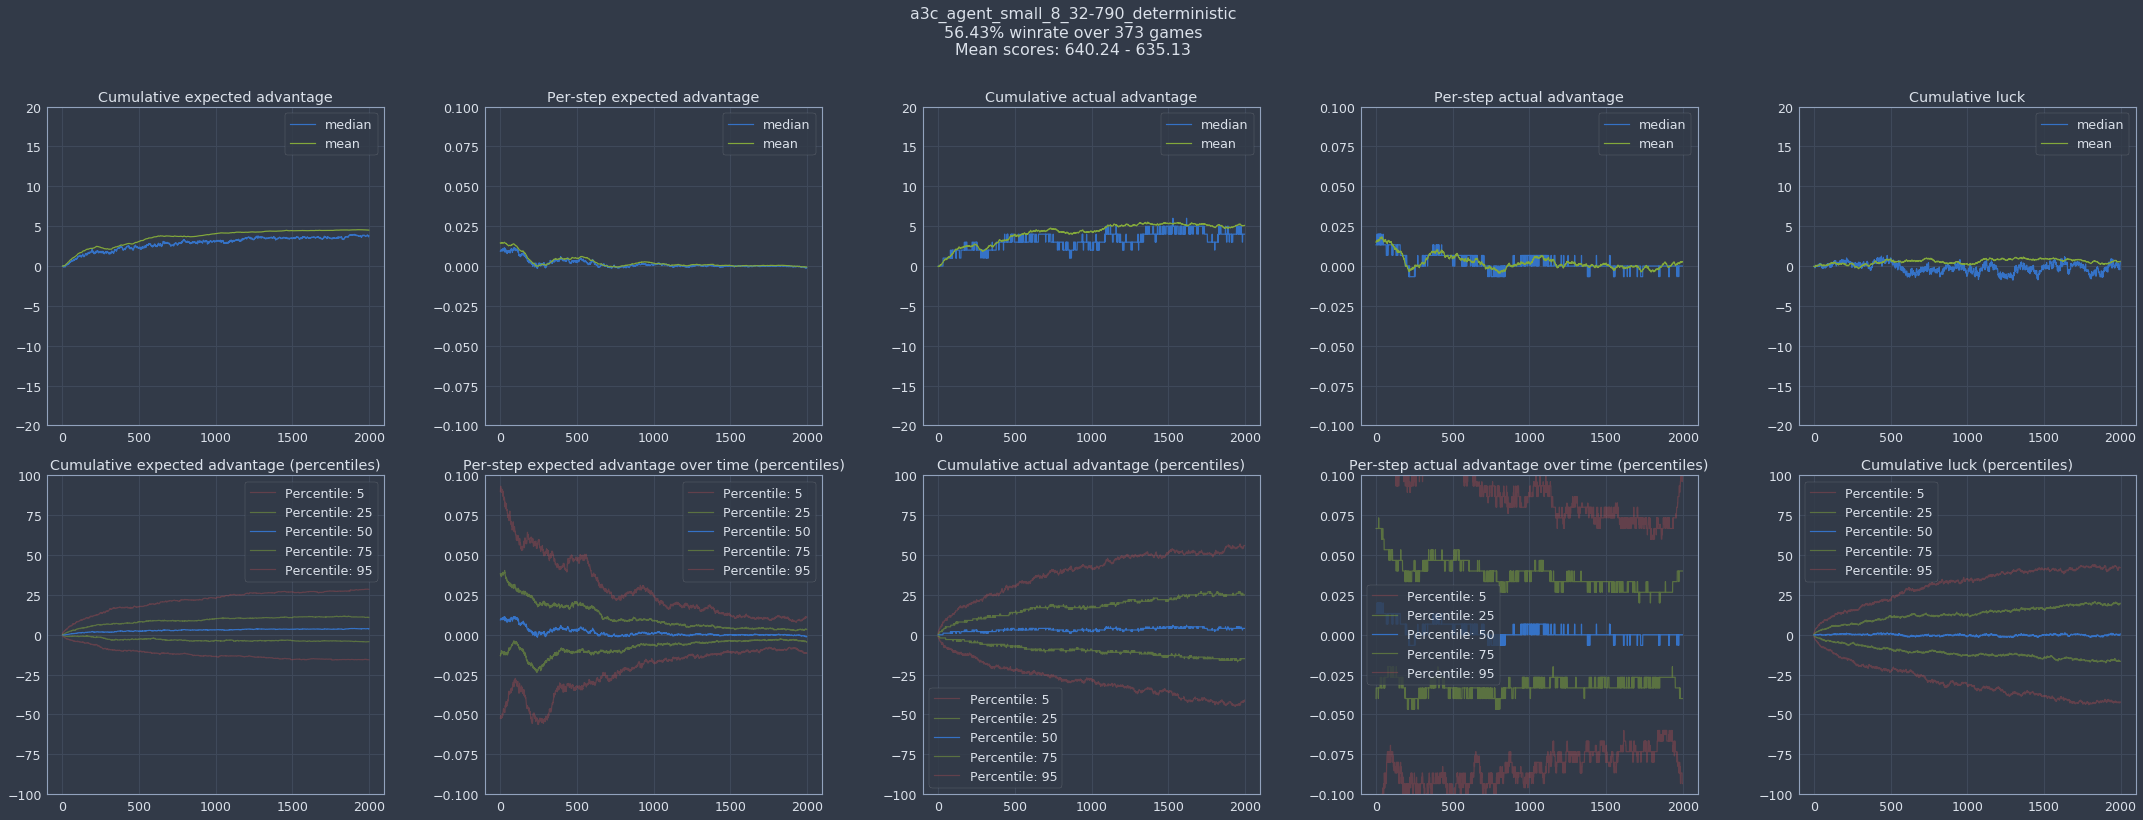

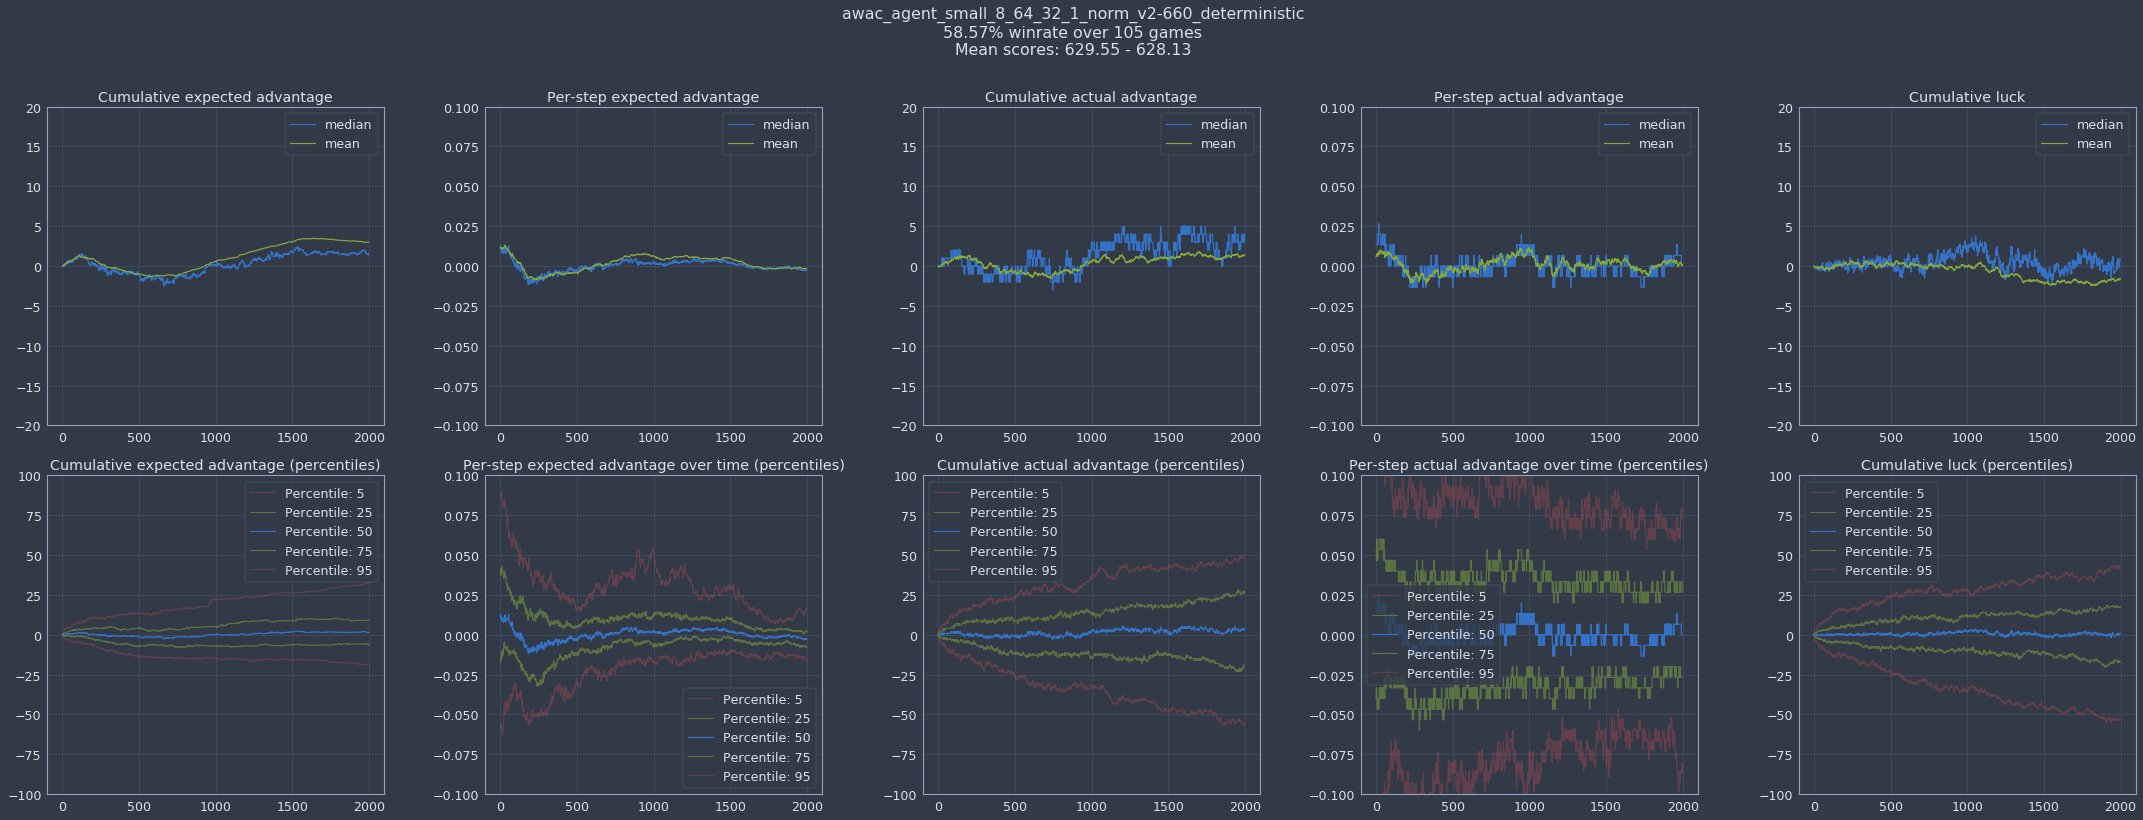

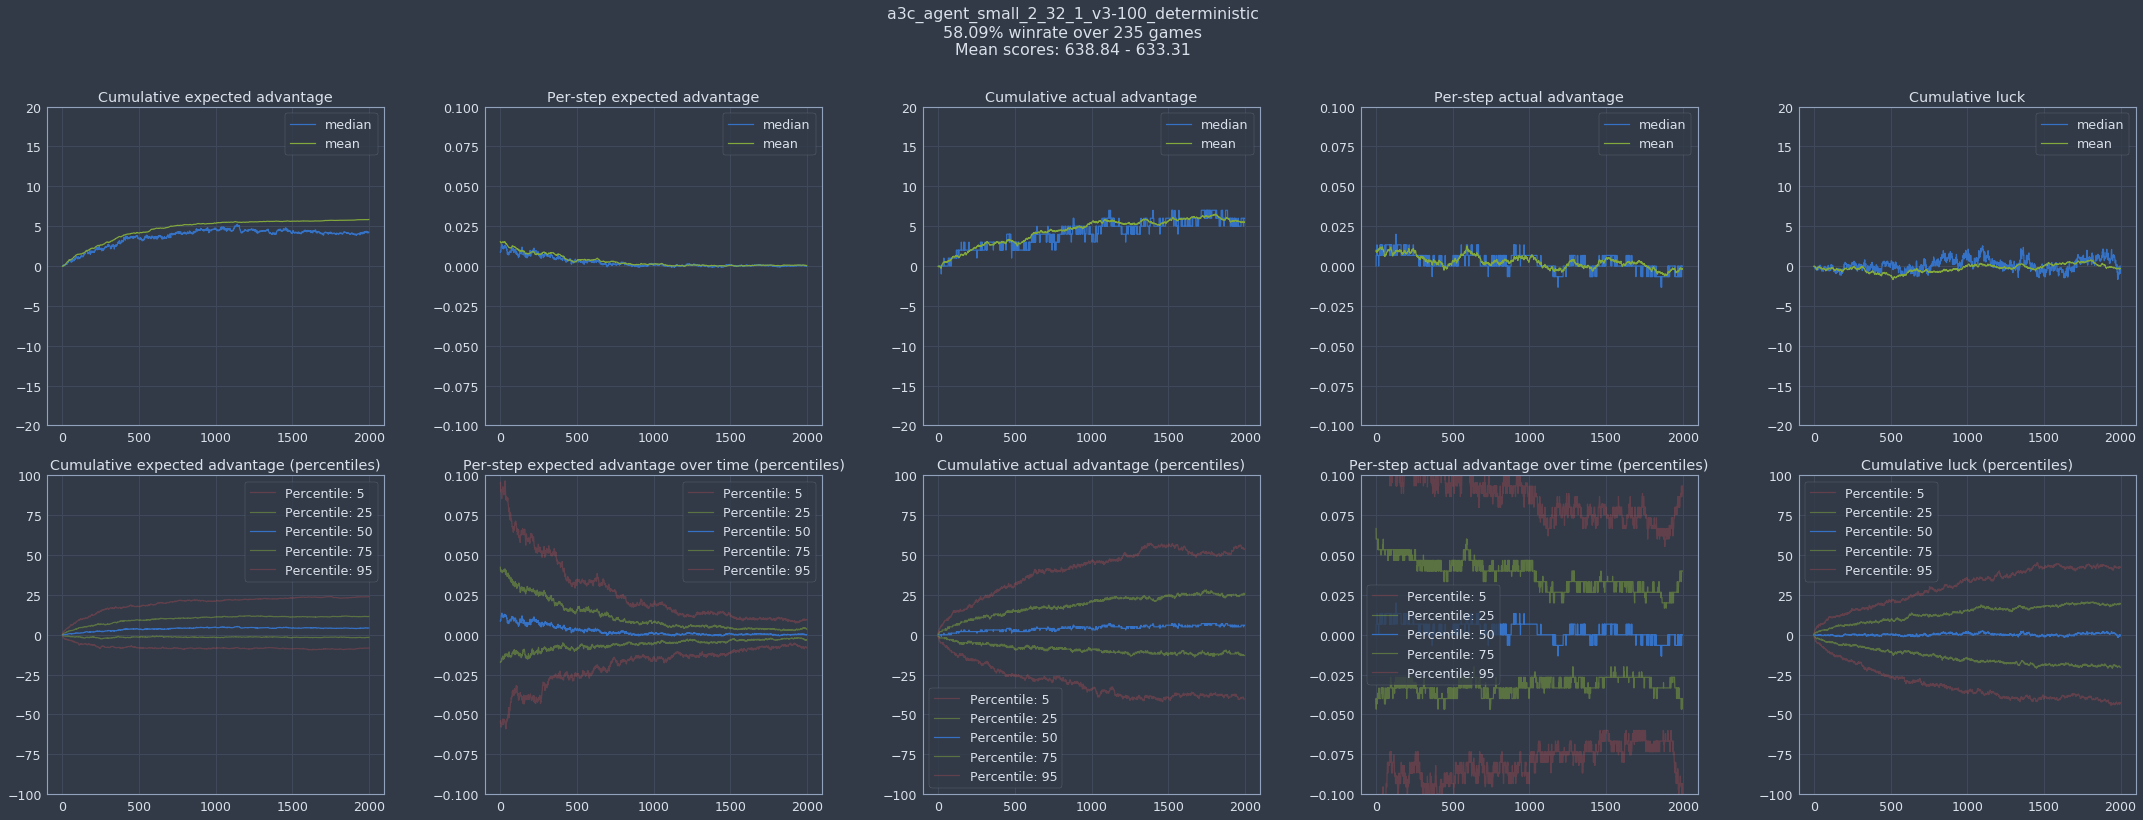

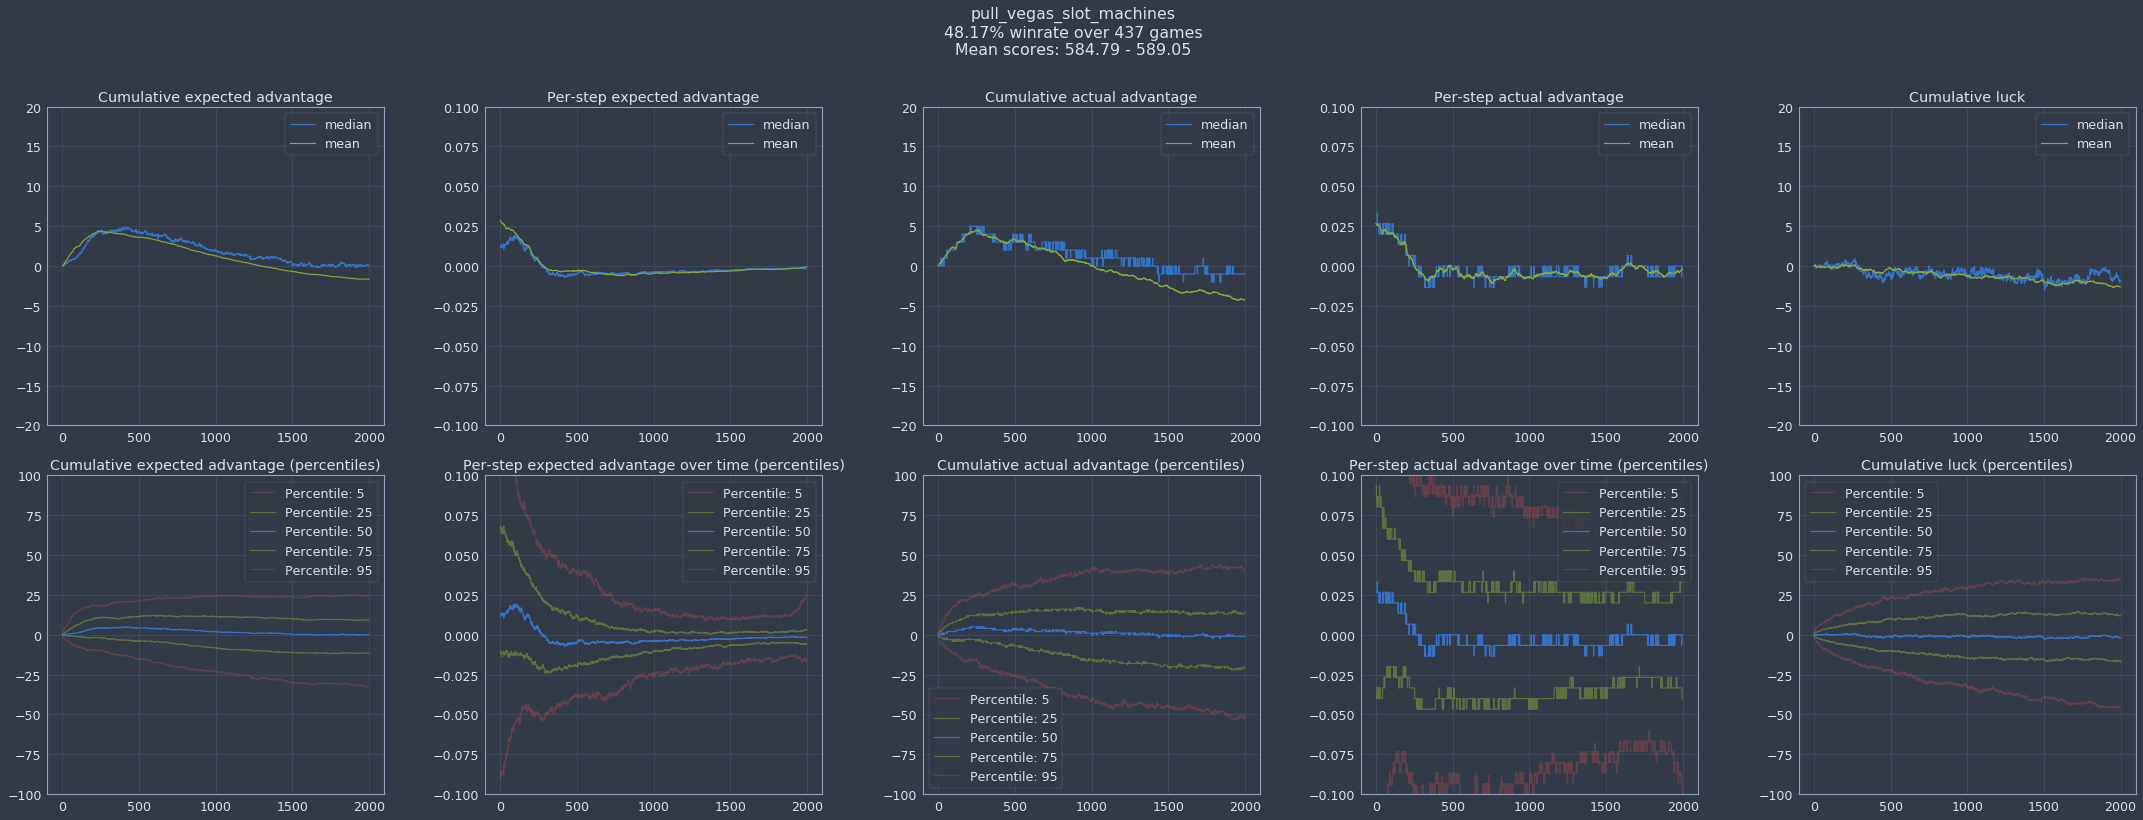

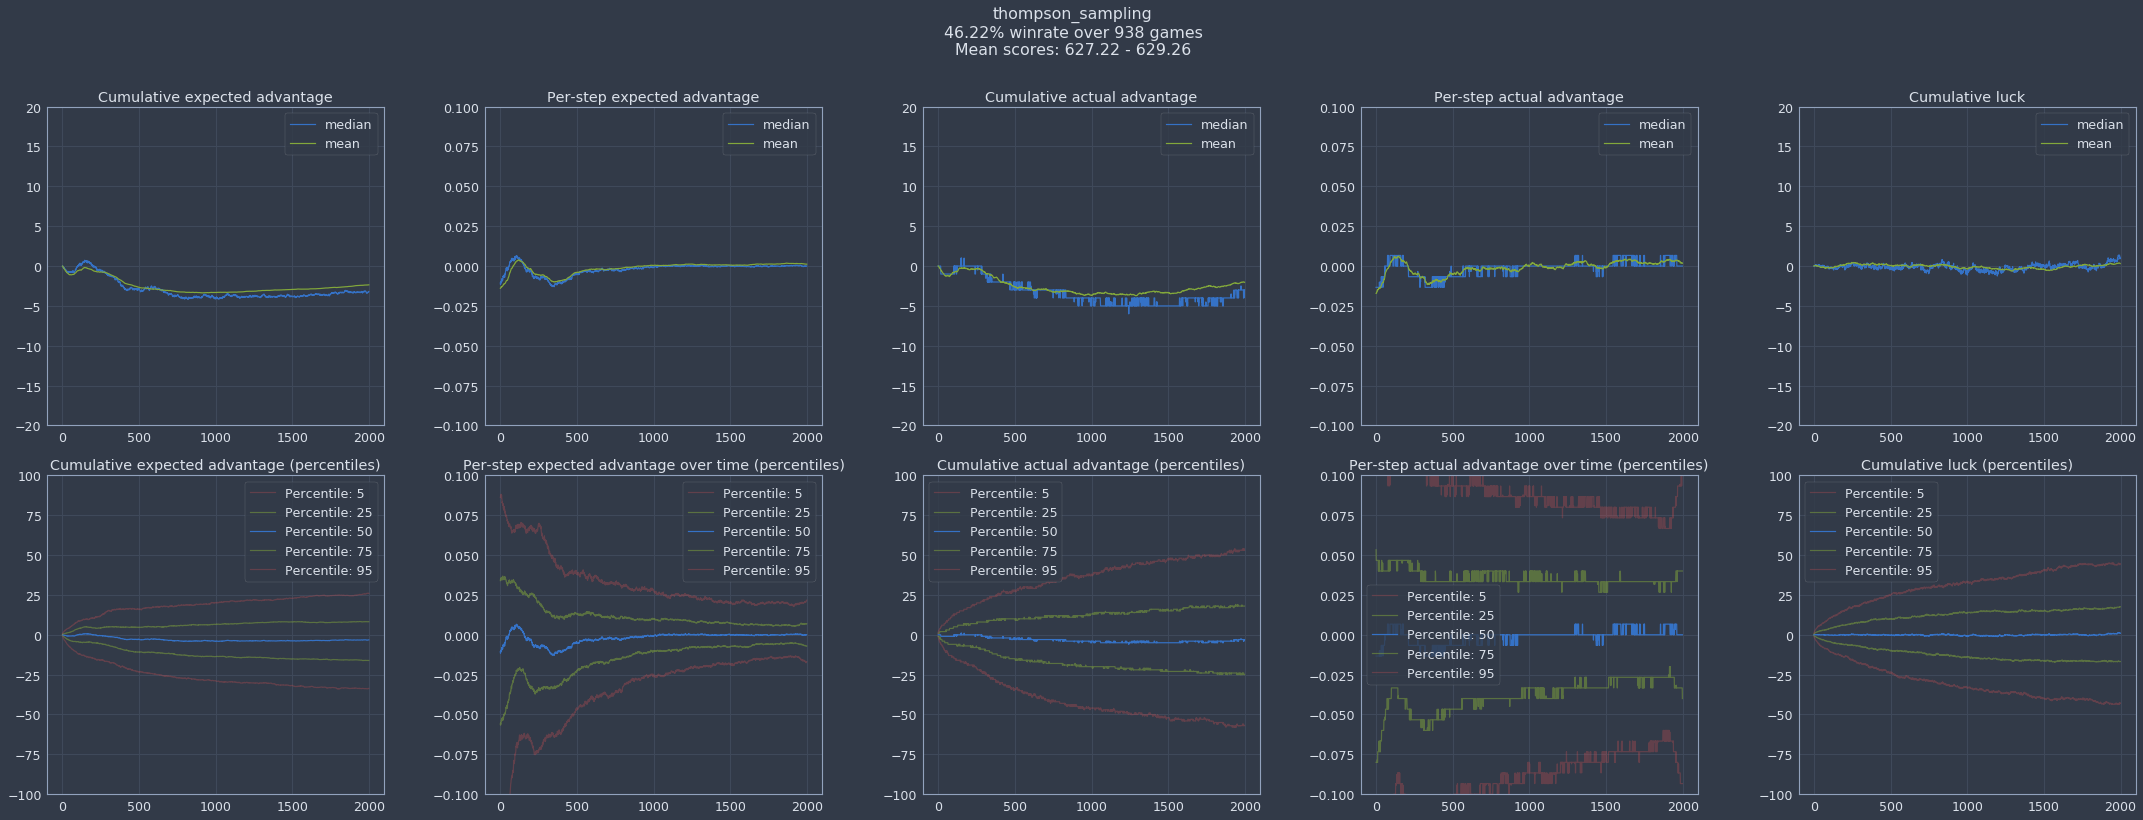

In [25]:
for mn in list(sub_id_to_model_name_df['model_name'].unique()):
    generate_fig(model_name=mn)